In [63]:
%load_ext autoreload
% autoreload 2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='serif')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from geant_dataloader import rtnpy_load_data
from logistics import *
import random
import datetime
from decimal import Decimal
from matplotlib import gridspec

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
print(torch.__version__)

from CVAE_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0a0+200fb22


##### CVAE 

Has input of y label at different points 

![CVAE](https://3.bp.blogspot.com/-X-2BF2ZJzlE/WVDBq5YaD_I/AAAAAAAADE0/IXhdDWg8L9oS_fR5kT9iTK8gQOoLullXgCLcBGAs/s1600/conditional_vae.pdf)

In [64]:
#currently working on 32 x32 implementation


torch.manual_seed(423312)
imageSize = 32
batchSize = 20
manualSeed = None
ngpu = 1
mydir=None # will be updated before the run
norm_scale = 'none'
epoch=0 #will be updated during the run
num_epochs = 100
nc =1
ndf = 64
ngf = 64
beta = 2.5
energy = "100and800and1800MeV"
energies_list, _ = normalize(np.array([800,100,1800]),norm_scale='1to10')
MeV800_test = np.full(5000, energies_list[0])
MeV100_test = np.full(5000, energies_list[1])
MeV1800_test = np.full(5000, energies_list[2])
conditions_lists= [MeV100_test, MeV800_test, MeV1800_test]
unnormalize_loss = False

if imageSize == 64:
    zdim = 128
else:
    zdim = 100
log_interval = 250

mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []
train_losses = []
test_losses = []
sum_differences = []

In [65]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)
        

('Random Seed: ', 8019)
Using Cuda
cuda:0
('Using:', 'gpu', 0L)


In [66]:
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
#image_array1 = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npy", num_events = None, image_size = imageSize)
image_array_800MeV = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize)+"ImageSize_800MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)
image_array_100MeV = rtnpy_load_data("numpy_data/geant4Data_25000Events_"+str(imageSize)+"ImageSize_100MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)
image_array_1800MeV = rtnpy_load_data("numpy_data/geant4Data_20000Events_"+str(imageSize)+"ImageSize_1800MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)



MeV800 = np.full((image_array_800MeV.shape[0]), 800.)
MeV100 = np.full((image_array_100MeV.shape[0]), 100.)
MeV1800 = np.full((image_array_1800MeV.shape[0]), 1800)
MeVs = np.concatenate((MeV800,MeV100, MeV1800),axis=0)
#MeVs = MeVs[...,np.newaxis]
MeVs, scale_MeVs = normalize(MeVs[...,np.newaxis],norm_scale='1to10')
images = np.concatenate((image_array_800MeV, image_array_100MeV, image_array_1800MeV),axis=0)
print images.shape, MeVs.shape
#image_array = [images, MeVs]

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

images, MeVs = unison_shuffled_copies(images,MeVs)
#image_array_100MeV = zip(image_array_100MeV, MeV100)

#print norm_scale
normed_array, scale = normalize(images, norm_scale = norm_scale )

tensor_array_train = torch.stack([torch.Tensor(i) for i in normed_array[:50000]])
tensor_labels_train = torch.stack([torch.Tensor(np.array(i)) for i in MeVs[:50000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train, tensor_labels_train)

tensor_array_test = torch.stack([torch.Tensor(i) for i in normed_array[50000:]])
tensor_labels_test = torch.stack([torch.Tensor(np.array(i)) for i in MeVs[50000:]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test, tensor_labels_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=8)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 8)
# for i, (data) in enumerate(train_loader,0):
#     data, energies = data[0].to(device)
#     print data, energies
#     break

#image_array=np.concatenate((image_array1, image_array2),0)

(74790, 1, 32, 32) (74790, 1)


In [113]:

def make_samples(model, avg, conditions, scale, norm_scale, zdim, device, imageSize, normed_array, n_events=500, real=True, fake = True):
    
    sample = torch.randn(n_events, zdim).to(device)
    #print sample.shape
    energies = torch.tensor(np.random.choice(np.squeeze(conditions), size=n_events)).type(torch.FloatTensor).to(device).unsqueeze(1)
    #print energies.shape
    sample_conds = torch.cat((sample,energies),1)
    gen_sample = model.decode(sample_conds).cpu()
    sample_new = gen_sample.view(n_events, 1, imageSize, imageSize).detach().numpy().squeeze()
    fake_images_array = unnormalize(sample_new, scale = scale, norm_scale = norm_scale)
    
    
    randints = np.random.randint(low = 0,high = normed_array.shape[0], size = n_events)
    real_images_array = unnormalize(normed_array[randints].squeeze(),norm_scale = norm_scale, scale = scale)
    
    
    # if you want the average image, take the mean. if not, will return a whole set of images
    if avg == True:
        fake_images_array = np.sum(fake_images_array,axis=0) / n_events
        real_images_array = np.sum(real_images_array, axis=0) / n_events
    
    if real == True and fake == True:
        return [real_images_array,fake_images_array], n_events
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array
    

def to_img(x, norm_scale = norm_scale, scale = scale, imageSize=imageSize):
    x = x.cpu().data.numpy()
    #x = 0.5 * (x + 1)
   # print x
   # x = np.clip(x, 0, 1)
    
    # this just drops the channel axis
    x = x.reshape([-1, imageSize, imageSize])

    x = unnormalize(x, scale = scale, norm_scale = norm_scale)
    #print x.max()
    
    return x

def plot_reconstructions(model, save_dir=None, epoch = epoch, latent_dim = zdim, conv=False, simple=False, n=4, imageSize=imageSize, norm_scale = norm_scale, batchSize = batchSize, scale = scale):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, energies = next(iter(test_loader))
    print data.shape,energies.shape

    
    if imageSize == 64:
        full_dim = 4096
    elif imageSize == 32:
        full_dim = 1024
    
    if not conv:
        data = data.view([-1, full_dim])
        data_energy = torch.cat((data,energies),1)
    true_imgs = data
    decoded_imgs, _, _ = model.forward(data_energy.to(device), energies.to(device))
    true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
    decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
    #print(decoded_imgs.shape)
    
    rowsize = n * 2.5
    columnsize = 4
    fig, axn = plt.subplots(figsize=(rowsize, columnsize))
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    for i in range(n):
        
        # display original
        ax = plt.subplot(2, n, i + 1)

        if i == 0:
            im = plt.imshow(true_imgs[i], cmap=cmap)
        else: 
            plt.imshow(true_imgs[i], cmap=cmap)

        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        if i == 0:
            ax.set_ylabel("Real", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.25,0.5)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap=cmap)
        print(decoded_imgs[i].min(), decoded_imgs[i].max())
        if i == 0:
            ax.set_ylabel("Decoded", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.3,0.5)

        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    fig.subplots_adjust(wspace=-0.185, hspace=0.09)
    fig.suptitle(r"VAE Real and Decoded Samples of $e^{-}$ $E_{dep}$, "+ str(latent_dim) + " Latent Dim ", x=0.52, y = 1.02)
          
    if save_dir != None:
        #learning_rate = '%.0E' % Decimal(lr)
      
        filename = "VAE_EdepFor" + str(n) + "Events_" + str(latent_dim) +"latentDim_"+ str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize.pdf"
 
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    
    return



def plot_conditional_means(model, conditions_lists, scale = scale, norm_scale = norm_scale, 
                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000, save_dir=None, w_EventMeans = False):

    data_avg_100, n_events = make_samples(model, avg = True, conditions= conditions_lists[0], scale = scale, norm_scale = norm_scale, 
                                          zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_800, n_events = make_samples(model, avg = True, conditions= conditions_lists[1], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_1800, n_events = make_samples(model, avg = True, conditions= conditions_lists[2], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    
    
    
    if w_EventMeans == True:
        data_100, n_events = make_samples(model, avg = False, conditions= conditions_lists[0], scale= scale, norm_scale = norm_scale, 
                                  zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 500)
        data_800, n_events = make_samples(model, avg = False, conditions= conditions_lists[1], scale= scale, norm_scale = norm_scale, 
                                  zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 500)
        data_1800, n_events = make_samples(model, avg = False, conditions= conditions_lists[2], scale= scale, norm_scale = norm_scale, 
                                  zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 500)
        
        MeV100_means = [x.sum() for x in data_100[1]]
        MeV800_means = [x.sum() for x in data_800[1]]
        MeV1800_means = [x.sum() for x in data_1800[1]]
        energy100 = [100 for i in data_100[1]]
        energy800 = [800 for i in data_800[1]]
        energy1800 = [1800 for i in data_1800[1]]
        
        
    MeV100_mean = data_avg_100[1].sum()
    MeV800_mean = data_avg_800[1].sum()
    MeV1800_mean = data_avg_1800[1].sum()

    MeV100_real = image_array_100MeV.mean(0).sum()
    MeV800_real = image_array_800MeV.mean(0).sum()
    MeV1800_real = image_array_1800MeV.mean(0).sum()
    print(MeV1800_real, MeV1800_mean)

    fig = plt.figure(figsize=(5.7,5.7))
    plt.ylim(-200,2000)
    #plt.xlim(0, 180)
    plt.scatter(MeV100_mean, 100, marker='P', s=150, alpha = 0.85, color = 'red', label = '100 MeV')
    plt.scatter(MeV100_real, 100, marker = 's', s = 100, alpha = 0.65, color = 'black')

    plt.scatter(MeV800_mean, 800, marker='P', s=150, alpha = 0.85, color = 'green', label = '800 MeV')
    plt.scatter(MeV800_real, 800, marker = 's', s = 100, alpha = 0.65, color = 'black')

    plt.scatter(MeV1800_mean, 1800, marker='P', s=150, alpha = 0.85, color= u'#ff7f0e', label = '1800 MeV')
    plt.scatter(MeV1800_real, 1800, marker = 's', s = 100, alpha = 0.65, color = 'black',  label = 'real')
    
    if w_EventMeans == True:
        plt.scatter(MeV100_means, energy100, marker='o', s=85, alpha = 0.015, color = 'red')
        plt.scatter(MeV800_means, energy800, marker='o', s=85, alpha = 0.015, color = 'green')
        plt.scatter(MeV1800_means, energy1800, marker='o', s=85, alpha = 0.015, color = u'#ff7f0e')
    
    plt.xlim(-50, 600)
    

    #plt.ylim(-200,2000)
    #plt.xlim(-.05, 0.40)
    plt.title(r"$\beta$-CVAE Mean $E_{dep}$ based on $e^-$ Energy, $\beta$ = " + str(beta), fontsize = 13.5)
    plt.xlabel(r"Mean $\mathit{E_{dep}} \; \, (MeV) $", fontsize=12, fontweight='light', alpha = 0.7)
    plt.ylabel(r"Gun Energy $(MeV)$", fontsize=12, fontweight='light', alpha = 0.7)
    #plt.xticks(np.arange(0, MeV1800_real + 0.1, step=0.1))
    plt.legend(loc='best', bbox_to_anchor=(1., 0.25), fontsize=10)
    sns.despine(left=False)
    
    if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "CVAE_MeanEdepComp" + str(n_events) + "Events_Epochs" + str(epoch) +" .pdf" 
            plt.savefig(save_dir + filename)
    
    plt.show()
    
    return

In [68]:
if imageSize == 64:
    full_dim = 4096
    leakiness = 0.03
elif imageSize == 32:
    full_dim = 1024
    leakiness = 0.04
    
cond_dim = 1
    
if norm_scale == 'sigmoid' or norm_scale == 'unif':
    #last_decode_act = nn.LeakyReLU(0.01)
    last_decode_act = F.leaky_relu
    #last_decode_act = F.sigmoid
elif norm_scale == '-1to1' or norm_scale == 'tanh':
    last_decode_act = F.tanh
elif norm_scale == 'none' or norm_scale == '1to10':
    last_decode_act = F.leaky_relu

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

#         self.fc1 = nn.Linear(full_dim + cond_dim, 300)
#         #self.fc12  = nn.Linear(650,400)
#         self.fc21 = nn.Linear(300, zdim)
#         self.fc22 = nn.Linear(300, zdim)
#         self.fc3 = nn.Linear(zdim + cond_dim, 300)
#         #self.fc31 = nn.Linear(400, 200)
#         self.fc4 = nn.Linear(300, full_dim)

        self.fc1 = nn.Linear(full_dim + cond_dim, 800)
        self.fc1a = nn.Linear(800, 400)
        self.fc1b = nn.Linear(400, 200)
        self.fc21 = nn.Linear(200, zdim)
        self.fc22 = nn.Linear(200, zdim)
        self.fc3 = nn.Linear(zdim + cond_dim, 200)
        self.fc3a = nn.Linear(200, 400)
        self.fc3b = nn.Linear(400, 800)
        self.fc4 = nn.Linear(800, full_dim)
        

#     def encode(self, x):
#         h1 = (F.leaky_relu(self.fc1(x)))
#         return self.fc21(h1), self.fc22(h1)
    def encode(self, x):
        #h1 = F.relu(self.fc1(x))
        h1 = F.leaky_relu(F.leaky_relu(self.fc1b(self.fc1a(F.relu(self.fc1(x))))), 0.01)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         #return F.leaky_relu(self.fc4(h3), leakiness)
#         #return F.sigmoid(self.fc4(h3))
#         if last_decode_act == F.leaky_relu:
#             return last_decode_act(self.fc4(h3), leakiness)
#         else:
#             return last_decode_act(self.fc4(h3))
#         #return F.relu(self.fc4(h3))


    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        return F.leaky_relu(self.fc4(F.leaky_relu(self.fc3b(F.leaky_relu(self.fc3a(h3))))), leakiness)
        #return F.leaky_relu(self.fc4((h3)), leakiness)
        #return self.fc4((h3))
        #return F.sigmoid(self.fc4(h3))
        #return last_decode_act(self.fc4(h3), leakiness)
        #return F.relu(self.fc4(h3))

    def forward(self, x, conds):
        mu, logvar = self.encode(x.view(-1, full_dim + cond_dim))
        z = self.reparameterize(mu, logvar)
        #conditional part
        z_conds = torch.cat((z,conds), 1)
        return self.decode(z_conds), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta = beta, full_dim = full_dim, scale= scale, norm_scale =norm_scale, unnormalize_loss = False):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1024), size_average=False)
    if unnormalize_loss == True:
        recon_x = unnormalize(recon_x, scale=scale, norm_scale = norm_scale)
        x = unnormalize(x, scale= scale, norm_scale = norm_scale)
    MSE = F.mse_loss(recon_x, x.view(-1,full_dim), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta*KLD


def train(epoch, train_losses):
    model.train()
    train_loss = 0
    for batch_idx, (data_and_conds) in enumerate(train_loader,):
        data = data_and_conds[0].to(device).view([-1, full_dim])
        #print data.shape
        energies = data_and_conds[1].to(device)
        #print energies.shape
        data_energies = torch.cat((data,energies), 1)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_energies, energies)
        loss = loss_function(recon_batch, data, mu, logvar, beta = beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    avg_batch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_batch_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_batch_loss))


def test(epoch, test_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data_and_conds) in enumerate(test_loader,0):
            data = data_and_conds[0].to(device).view([-1, full_dim])
            energies = data_and_conds[1].to(device)
            data_energies = torch.cat((data,energies), 1)
            recon_batch, mu, logvar = model(data_energies, energies)
            test_loss += loss_function(recon_batch, data, mu, logvar, beta = beta).item()
           # if i == 0:
           #     n = min(data.size(0), 8)
               # comparison = torch.cat([data[:n],
                #                      recon_batch.view(batchSize, 1, imageSize, imageSize)[:n]])
                #save_image(comparison.cpu(),
                #         'results/reconstruction_' + str(epoch) + '.pdf', nrow=n)
                
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

print(model)


VAE(
  (fc1): Linear(in_features=1025, out_features=800, bias=True)
  (fc1a): Linear(in_features=800, out_features=400, bias=True)
  (fc1b): Linear(in_features=400, out_features=200, bias=True)
  (fc21): Linear(in_features=200, out_features=100, bias=True)
  (fc22): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=101, out_features=200, bias=True)
  (fc3a): Linear(in_features=200, out_features=400, bias=True)
  (fc3b): Linear(in_features=400, out_features=800, bias=True)
  (fc4): Linear(in_features=800, out_features=1024, bias=True)
)


(325.5882891382654, 274.65015)


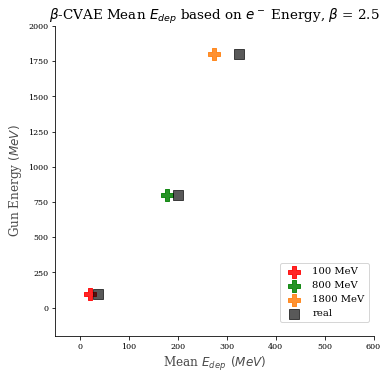

Train Epoch: 100 [0/50000 (0%)]	Loss: 196.018311
Train Epoch: 100 [5000/50000 (10%)]	Loss: 156.024780
Train Epoch: 100 [10000/50000 (20%)]	Loss: 186.124463
Train Epoch: 100 [15000/50000 (30%)]	Loss: 157.632373
Train Epoch: 100 [20000/50000 (40%)]	Loss: 179.663867
Train Epoch: 100 [25000/50000 (50%)]	Loss: 229.291919
Train Epoch: 100 [30000/50000 (60%)]	Loss: 175.633264
Train Epoch: 100 [35000/50000 (70%)]	Loss: 169.489893
Train Epoch: 100 [40000/50000 (80%)]	Loss: 197.321167
Train Epoch: 100 [45000/50000 (90%)]	Loss: 194.320874
====> Epoch: 100 Average loss: 184.1826
====> Test set loss: 188.5138


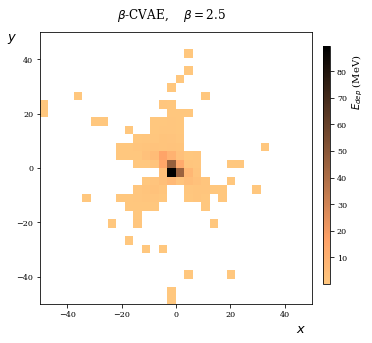

(325.5882891382654, 277.3261)


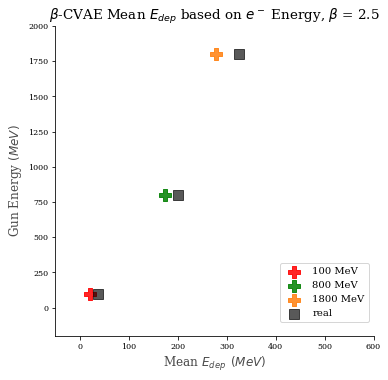

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.08143402, 14.001415)
(-0.14339723, 46.430252)
(-0.11466326, 26.143412)
(-0.036400978, 15.207403)
(-0.05058184, 45.95328)


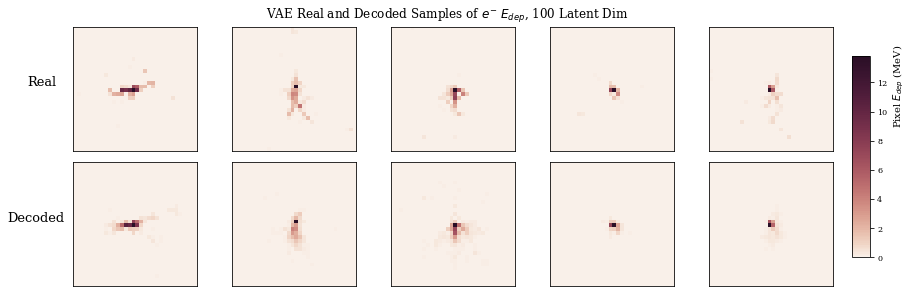

21.397743


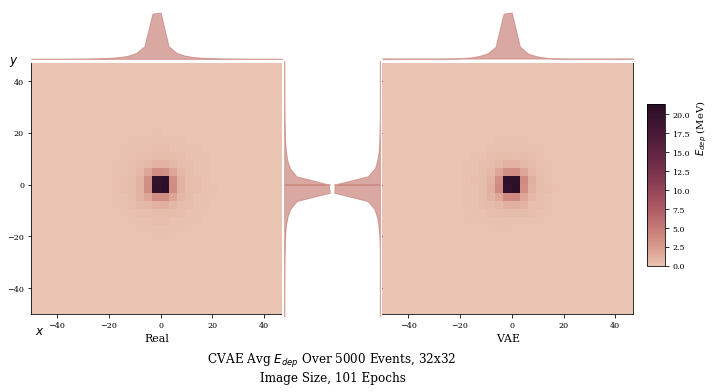

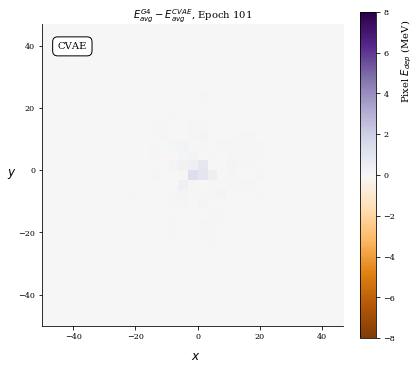

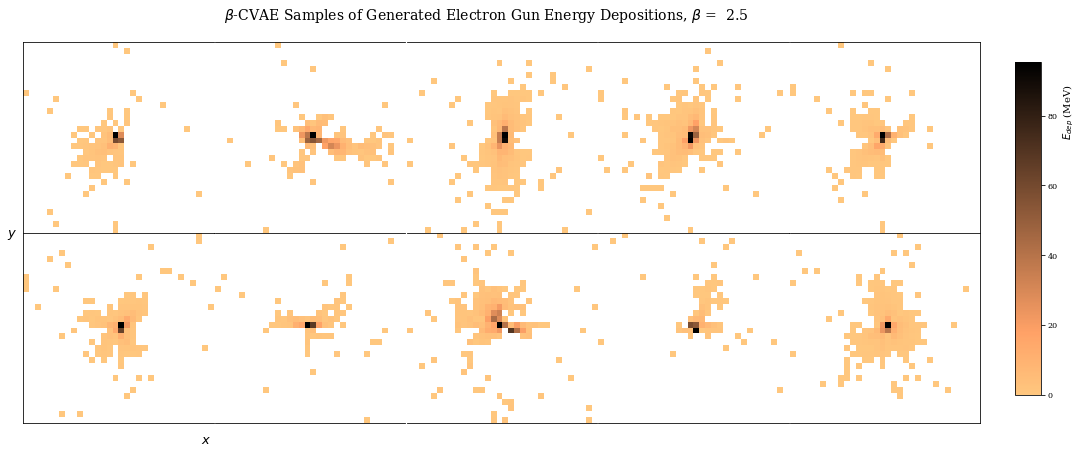

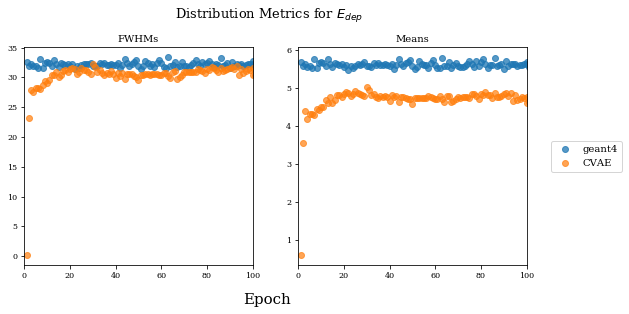

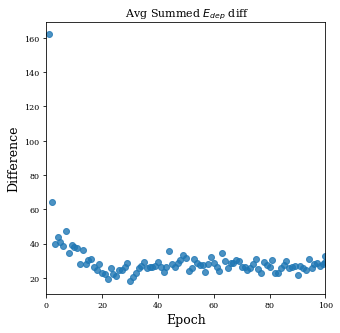

Train Epoch: 101 [0/50000 (0%)]	Loss: 196.379614
Train Epoch: 101 [5000/50000 (10%)]	Loss: 155.612720
Train Epoch: 101 [10000/50000 (20%)]	Loss: 184.103442
Train Epoch: 101 [15000/50000 (30%)]	Loss: 160.031897
Train Epoch: 101 [20000/50000 (40%)]	Loss: 171.880811
Train Epoch: 101 [25000/50000 (50%)]	Loss: 229.387231
Train Epoch: 101 [30000/50000 (60%)]	Loss: 173.672339
Train Epoch: 101 [35000/50000 (70%)]	Loss: 168.083154
Train Epoch: 101 [40000/50000 (80%)]	Loss: 199.157813
Train Epoch: 101 [45000/50000 (90%)]	Loss: 193.312427
====> Epoch: 101 Average loss: 183.8911
====> Test set loss: 190.5572


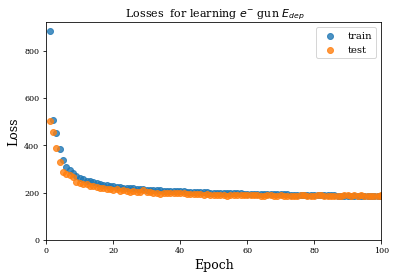

(325.5882891382654, 273.06885)


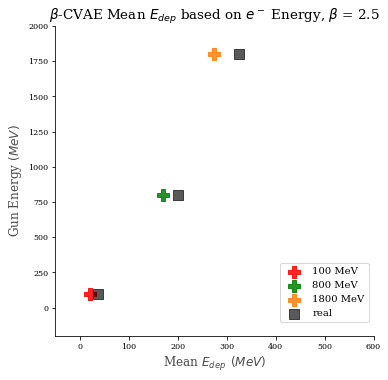

(325.5882891382654, 274.42603)


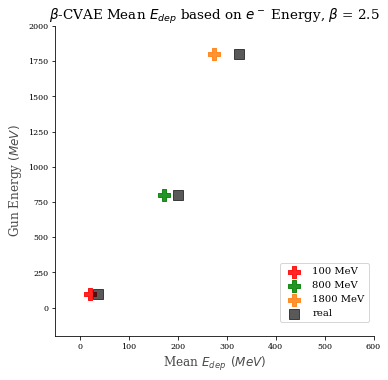

Train Epoch: 102 [0/50000 (0%)]	Loss: 199.958447
Train Epoch: 102 [5000/50000 (10%)]	Loss: 153.393408
Train Epoch: 102 [10000/50000 (20%)]	Loss: 183.564063
Train Epoch: 102 [15000/50000 (30%)]	Loss: 155.959961
Train Epoch: 102 [20000/50000 (40%)]	Loss: 173.584375
Train Epoch: 102 [25000/50000 (50%)]	Loss: 231.672754
Train Epoch: 102 [30000/50000 (60%)]	Loss: 177.863867
Train Epoch: 102 [35000/50000 (70%)]	Loss: 172.021655
Train Epoch: 102 [40000/50000 (80%)]	Loss: 195.809314
Train Epoch: 102 [45000/50000 (90%)]	Loss: 193.331409
====> Epoch: 102 Average loss: 183.8325
====> Test set loss: 189.4136
(325.5882891382654, 272.9713)


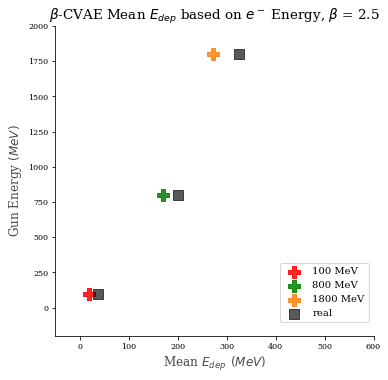

Train Epoch: 103 [0/50000 (0%)]	Loss: 201.005957
Train Epoch: 103 [5000/50000 (10%)]	Loss: 152.863489
Train Epoch: 103 [10000/50000 (20%)]	Loss: 186.769897
Train Epoch: 103 [15000/50000 (30%)]	Loss: 156.034619
Train Epoch: 103 [20000/50000 (40%)]	Loss: 176.726831
Train Epoch: 103 [25000/50000 (50%)]	Loss: 225.821973
Train Epoch: 103 [30000/50000 (60%)]	Loss: 172.999951
Train Epoch: 103 [35000/50000 (70%)]	Loss: 172.144397
Train Epoch: 103 [40000/50000 (80%)]	Loss: 196.780103
Train Epoch: 103 [45000/50000 (90%)]	Loss: 194.082275
====> Epoch: 103 Average loss: 183.6367
====> Test set loss: 191.1306
(325.5882891382654, 269.12543)


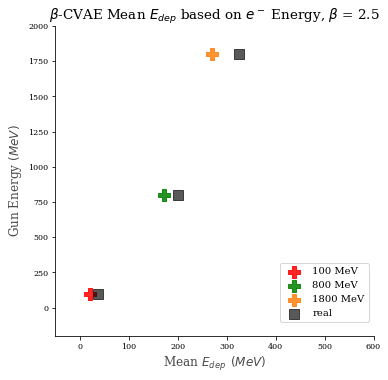

Train Epoch: 104 [0/50000 (0%)]	Loss: 196.463721
Train Epoch: 104 [5000/50000 (10%)]	Loss: 153.677661
Train Epoch: 104 [10000/50000 (20%)]	Loss: 181.376660
Train Epoch: 104 [15000/50000 (30%)]	Loss: 155.502490
Train Epoch: 104 [20000/50000 (40%)]	Loss: 177.961108
Train Epoch: 104 [25000/50000 (50%)]	Loss: 227.642236
Train Epoch: 104 [30000/50000 (60%)]	Loss: 175.974500
Train Epoch: 104 [35000/50000 (70%)]	Loss: 171.904761
Train Epoch: 104 [40000/50000 (80%)]	Loss: 196.206726
Train Epoch: 104 [45000/50000 (90%)]	Loss: 195.592993
====> Epoch: 104 Average loss: 183.3871
====> Test set loss: 188.1680
(325.5882891382654, 276.9261)


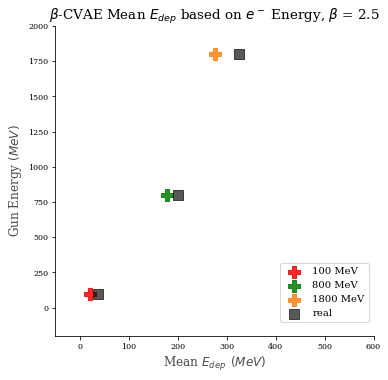

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.091220826, 15.536808)
(-0.1536925, 43.848698)
(-0.12981834, 26.690538)
(-0.045851044, 15.345688)
(-0.04598596, 45.39918)


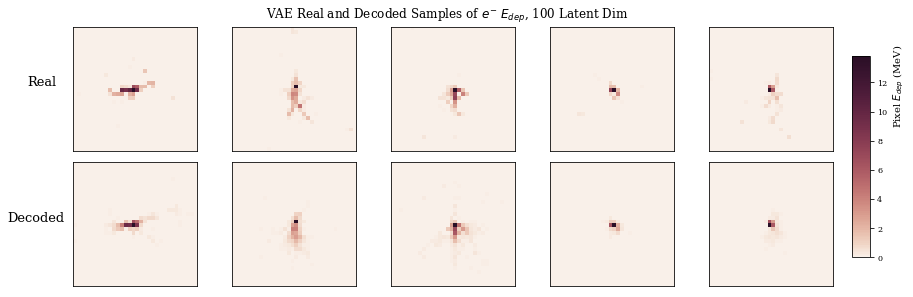

22.270313


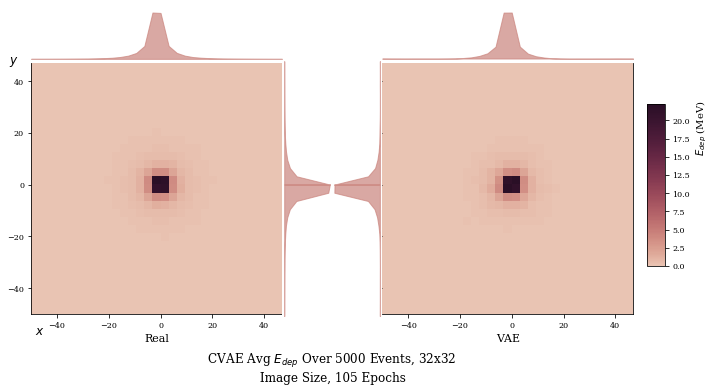

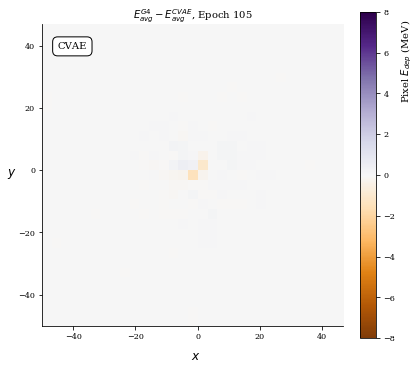

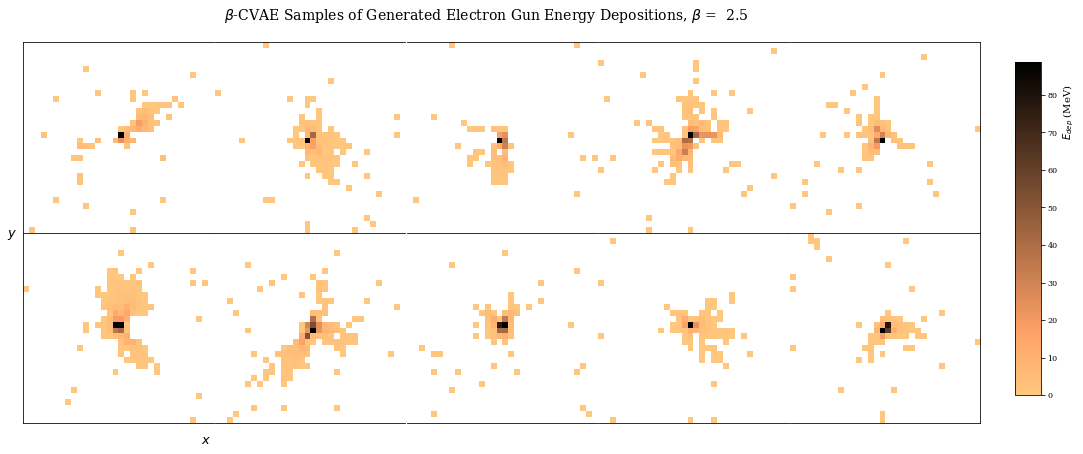

Train Epoch: 105 [0/50000 (0%)]	Loss: 197.136060
Train Epoch: 105 [5000/50000 (10%)]	Loss: 154.990088
Train Epoch: 105 [10000/50000 (20%)]	Loss: 184.220801
Train Epoch: 105 [15000/50000 (30%)]	Loss: 157.581982
Train Epoch: 105 [20000/50000 (40%)]	Loss: 180.710913
Train Epoch: 105 [25000/50000 (50%)]	Loss: 225.773877
Train Epoch: 105 [30000/50000 (60%)]	Loss: 175.840430
Train Epoch: 105 [35000/50000 (70%)]	Loss: 173.078333
Train Epoch: 105 [40000/50000 (80%)]	Loss: 195.448706
Train Epoch: 105 [45000/50000 (90%)]	Loss: 191.473499
====> Epoch: 105 Average loss: 182.9718
====> Test set loss: 188.8273
(325.5882891382654, 273.08685)


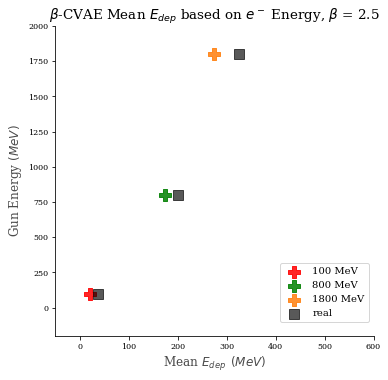

Train Epoch: 106 [0/50000 (0%)]	Loss: 200.506592
Train Epoch: 106 [5000/50000 (10%)]	Loss: 156.025928
Train Epoch: 106 [10000/50000 (20%)]	Loss: 181.601001
Train Epoch: 106 [15000/50000 (30%)]	Loss: 157.325049
Train Epoch: 106 [20000/50000 (40%)]	Loss: 178.760193
Train Epoch: 106 [25000/50000 (50%)]	Loss: 230.290332
Train Epoch: 106 [30000/50000 (60%)]	Loss: 179.573767
Train Epoch: 106 [35000/50000 (70%)]	Loss: 175.928931
Train Epoch: 106 [40000/50000 (80%)]	Loss: 194.454883
Train Epoch: 106 [45000/50000 (90%)]	Loss: 197.142456
====> Epoch: 106 Average loss: 182.9393
====> Test set loss: 188.4184
(325.5882891382654, 275.0473)


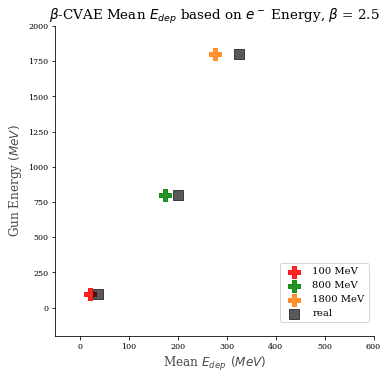

Train Epoch: 107 [0/50000 (0%)]	Loss: 199.608081
Train Epoch: 107 [5000/50000 (10%)]	Loss: 158.339380
Train Epoch: 107 [10000/50000 (20%)]	Loss: 183.671021
Train Epoch: 107 [15000/50000 (30%)]	Loss: 154.156714
Train Epoch: 107 [20000/50000 (40%)]	Loss: 172.028247
Train Epoch: 107 [25000/50000 (50%)]	Loss: 230.152002
Train Epoch: 107 [30000/50000 (60%)]	Loss: 180.936853
Train Epoch: 107 [35000/50000 (70%)]	Loss: 165.518994
Train Epoch: 107 [40000/50000 (80%)]	Loss: 197.891846
Train Epoch: 107 [45000/50000 (90%)]	Loss: 194.521338
====> Epoch: 107 Average loss: 182.6391
====> Test set loss: 186.9643
(325.5882891382654, 277.5195)


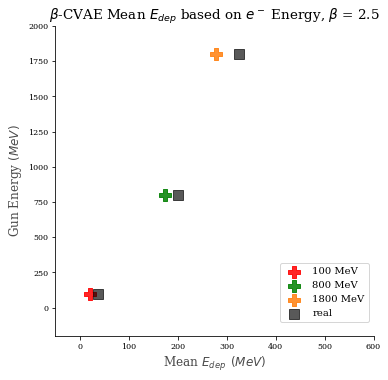

Train Epoch: 108 [0/50000 (0%)]	Loss: 194.350769
Train Epoch: 108 [5000/50000 (10%)]	Loss: 153.676587
Train Epoch: 108 [10000/50000 (20%)]	Loss: 185.349902
Train Epoch: 108 [15000/50000 (30%)]	Loss: 156.263599
Train Epoch: 108 [20000/50000 (40%)]	Loss: 175.886816
Train Epoch: 108 [25000/50000 (50%)]	Loss: 225.723804
Train Epoch: 108 [30000/50000 (60%)]	Loss: 181.568579
Train Epoch: 108 [35000/50000 (70%)]	Loss: 171.986182
Train Epoch: 108 [40000/50000 (80%)]	Loss: 196.312988
Train Epoch: 108 [45000/50000 (90%)]	Loss: 199.037476
====> Epoch: 108 Average loss: 182.5533
====> Test set loss: 188.3567
(325.5882891382654, 272.51782)


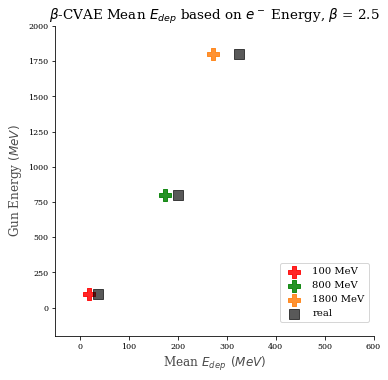

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.109967984, 14.6042)
(-0.15016042, 45.076756)
(-0.1291165, 26.131683)
(-0.037649132, 15.830861)
(-0.048073854, 45.31857)


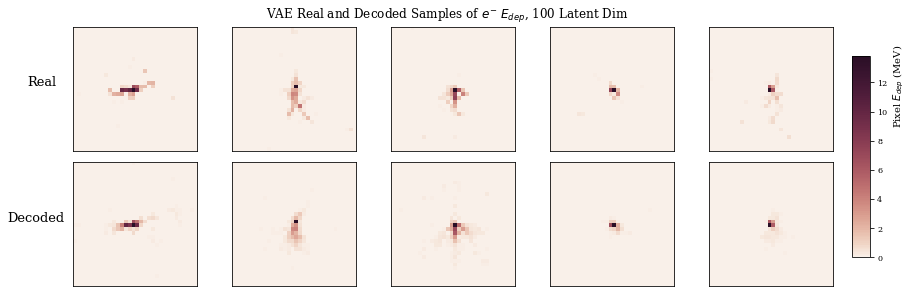

21.672543


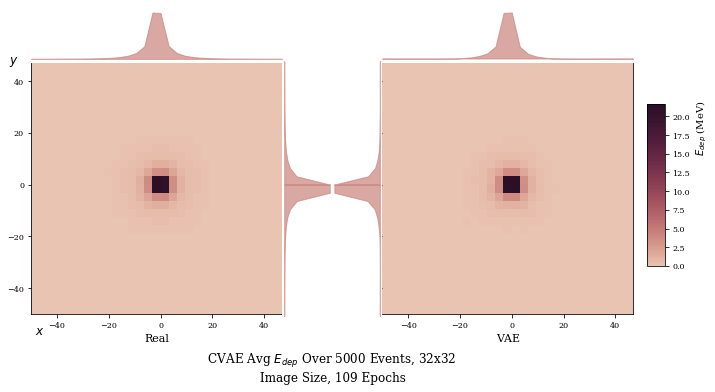

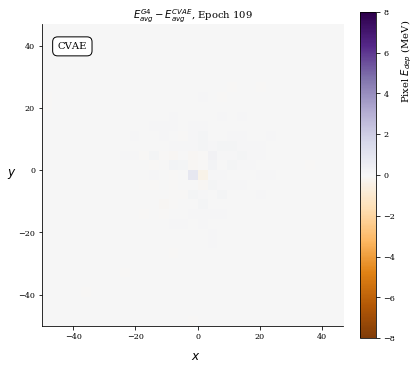

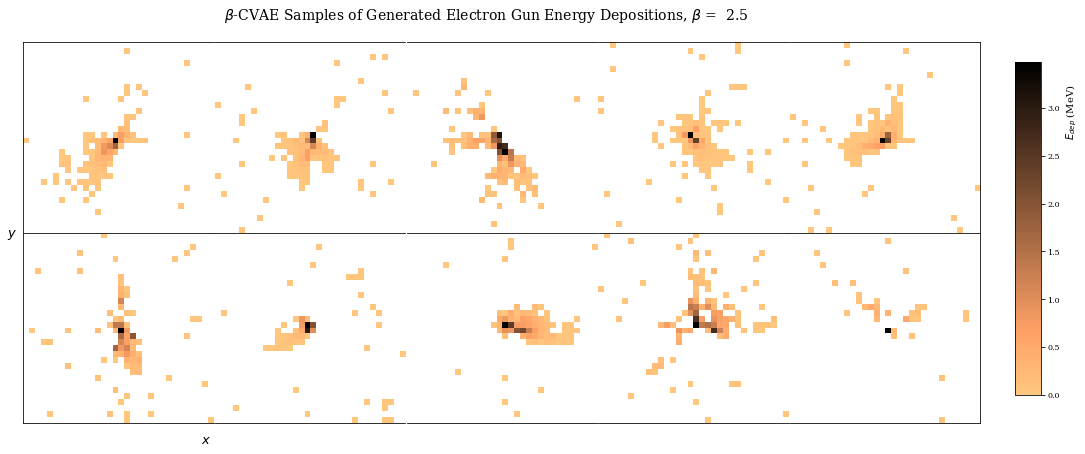

Train Epoch: 109 [0/50000 (0%)]	Loss: 195.710327
Train Epoch: 109 [5000/50000 (10%)]	Loss: 148.224072
Train Epoch: 109 [10000/50000 (20%)]	Loss: 182.585425
Train Epoch: 109 [15000/50000 (30%)]	Loss: 153.089343
Train Epoch: 109 [20000/50000 (40%)]	Loss: 175.398364
Train Epoch: 109 [25000/50000 (50%)]	Loss: 227.099707
Train Epoch: 109 [30000/50000 (60%)]	Loss: 181.175171
Train Epoch: 109 [35000/50000 (70%)]	Loss: 176.261011
Train Epoch: 109 [40000/50000 (80%)]	Loss: 193.843787
Train Epoch: 109 [45000/50000 (90%)]	Loss: 188.980908
====> Epoch: 109 Average loss: 182.4671
====> Test set loss: 187.8174
(325.5882891382654, 271.68457)


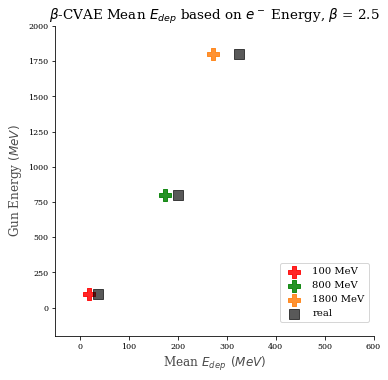

Train Epoch: 110 [0/50000 (0%)]	Loss: 196.557056
Train Epoch: 110 [5000/50000 (10%)]	Loss: 151.443506
Train Epoch: 110 [10000/50000 (20%)]	Loss: 186.057703
Train Epoch: 110 [15000/50000 (30%)]	Loss: 154.198523
Train Epoch: 110 [20000/50000 (40%)]	Loss: 173.998413
Train Epoch: 110 [25000/50000 (50%)]	Loss: 223.091797
Train Epoch: 110 [30000/50000 (60%)]	Loss: 178.161768
Train Epoch: 110 [35000/50000 (70%)]	Loss: 168.643140
Train Epoch: 110 [40000/50000 (80%)]	Loss: 196.395129
Train Epoch: 110 [45000/50000 (90%)]	Loss: 190.975476
====> Epoch: 110 Average loss: 182.2412
====> Test set loss: 189.8071
(325.5882891382654, 276.22754)


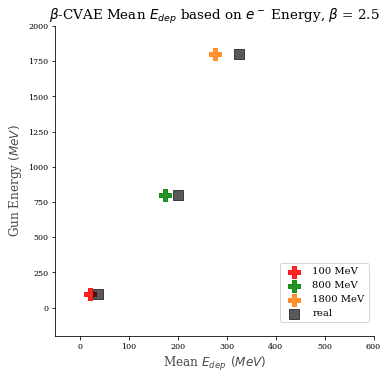

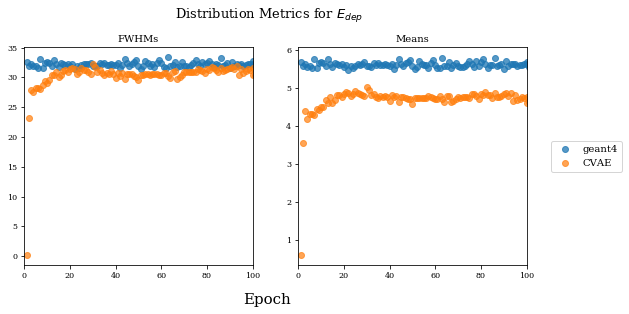

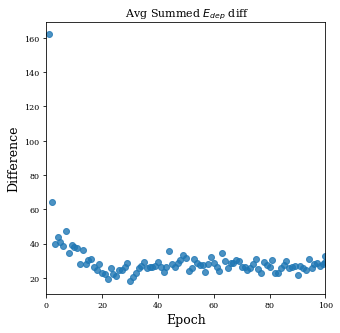

Train Epoch: 111 [0/50000 (0%)]	Loss: 200.597803
Train Epoch: 111 [5000/50000 (10%)]	Loss: 154.077063
Train Epoch: 111 [10000/50000 (20%)]	Loss: 185.325122
Train Epoch: 111 [15000/50000 (30%)]	Loss: 153.958691
Train Epoch: 111 [20000/50000 (40%)]	Loss: 175.035352
Train Epoch: 111 [25000/50000 (50%)]	Loss: 223.256128
Train Epoch: 111 [30000/50000 (60%)]	Loss: 176.171252
Train Epoch: 111 [35000/50000 (70%)]	Loss: 171.438696
Train Epoch: 111 [40000/50000 (80%)]	Loss: 194.361450
Train Epoch: 111 [45000/50000 (90%)]	Loss: 195.449316
====> Epoch: 111 Average loss: 181.9559
====> Test set loss: 187.1090


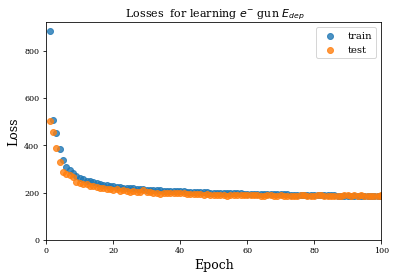

(325.5882891382654, 277.7574)


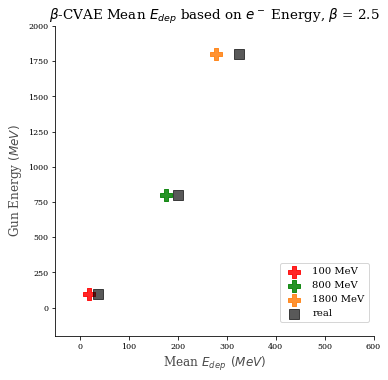

(325.5882891382654, 278.42398)


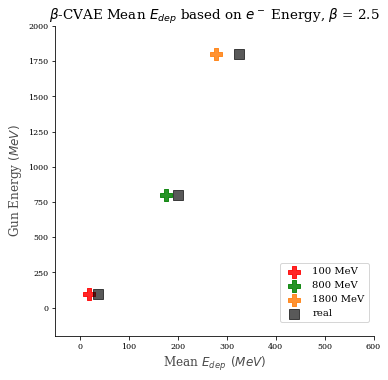

Train Epoch: 112 [0/50000 (0%)]	Loss: 192.487476
Train Epoch: 112 [5000/50000 (10%)]	Loss: 153.203918
Train Epoch: 112 [10000/50000 (20%)]	Loss: 179.416345
Train Epoch: 112 [15000/50000 (30%)]	Loss: 157.291797
Train Epoch: 112 [20000/50000 (40%)]	Loss: 173.868237
Train Epoch: 112 [25000/50000 (50%)]	Loss: 226.555713
Train Epoch: 112 [30000/50000 (60%)]	Loss: 176.065015
Train Epoch: 112 [35000/50000 (70%)]	Loss: 171.343579
Train Epoch: 112 [40000/50000 (80%)]	Loss: 189.233667
Train Epoch: 112 [45000/50000 (90%)]	Loss: 196.916504
====> Epoch: 112 Average loss: 182.2963
====> Test set loss: 187.3425
(325.5882891382654, 274.06024)


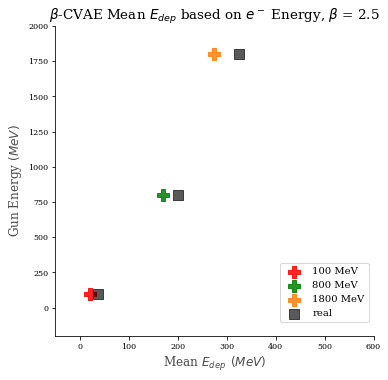

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.08509235, 15.12234)
(-0.14135644, 45.629684)
(-0.10876125, 26.048819)
(-0.03301116, 15.875602)
(-0.05464725, 45.135784)


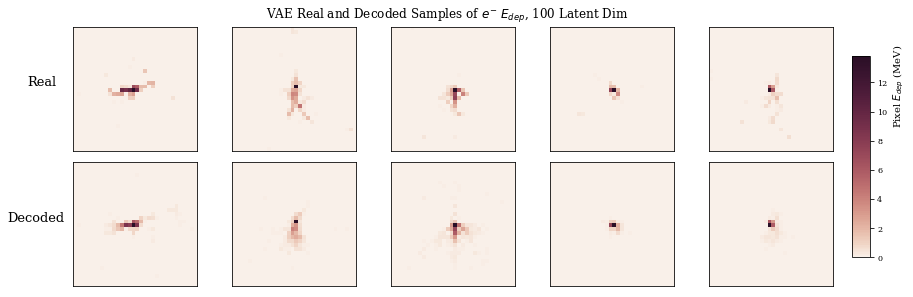

21.231684


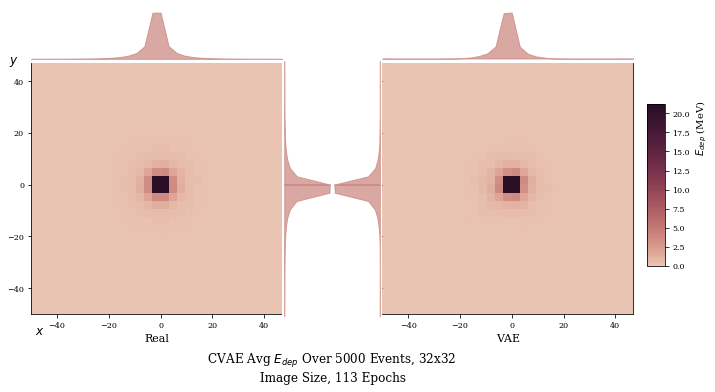

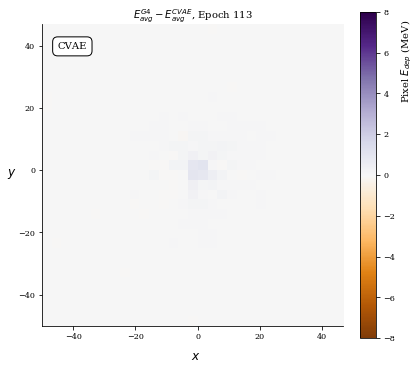

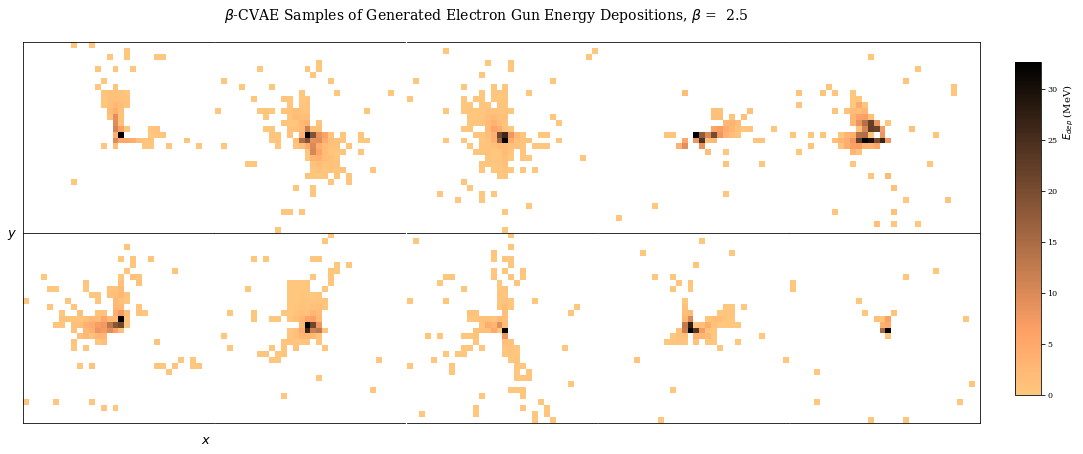

Train Epoch: 113 [0/50000 (0%)]	Loss: 198.199194
Train Epoch: 113 [5000/50000 (10%)]	Loss: 154.360657
Train Epoch: 113 [10000/50000 (20%)]	Loss: 188.904175
Train Epoch: 113 [15000/50000 (30%)]	Loss: 156.150293
Train Epoch: 113 [20000/50000 (40%)]	Loss: 171.781763
Train Epoch: 113 [25000/50000 (50%)]	Loss: 220.589258
Train Epoch: 113 [30000/50000 (60%)]	Loss: 174.196240
Train Epoch: 113 [35000/50000 (70%)]	Loss: 171.487646
Train Epoch: 113 [40000/50000 (80%)]	Loss: 195.316296
Train Epoch: 113 [45000/50000 (90%)]	Loss: 199.835864
====> Epoch: 113 Average loss: 181.6782
====> Test set loss: 186.3496
(325.5882891382654, 275.07068)


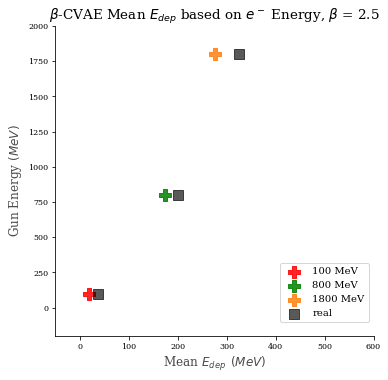

Train Epoch: 114 [0/50000 (0%)]	Loss: 195.439478
Train Epoch: 114 [5000/50000 (10%)]	Loss: 154.045703
Train Epoch: 114 [10000/50000 (20%)]	Loss: 182.773621
Train Epoch: 114 [15000/50000 (30%)]	Loss: 151.424097
Train Epoch: 114 [20000/50000 (40%)]	Loss: 177.473145
Train Epoch: 114 [25000/50000 (50%)]	Loss: 223.040454
Train Epoch: 114 [30000/50000 (60%)]	Loss: 177.244678
Train Epoch: 114 [35000/50000 (70%)]	Loss: 171.233936
Train Epoch: 114 [40000/50000 (80%)]	Loss: 193.465576
Train Epoch: 114 [45000/50000 (90%)]	Loss: 195.992017
====> Epoch: 114 Average loss: 181.4145
====> Test set loss: 189.5466
(325.5882891382654, 270.57806)


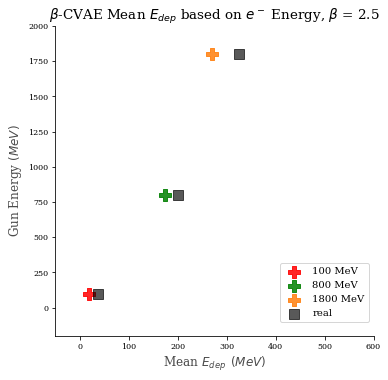

Train Epoch: 115 [0/50000 (0%)]	Loss: 192.186548
Train Epoch: 115 [5000/50000 (10%)]	Loss: 154.478613
Train Epoch: 115 [10000/50000 (20%)]	Loss: 180.104773
Train Epoch: 115 [15000/50000 (30%)]	Loss: 153.353149
Train Epoch: 115 [20000/50000 (40%)]	Loss: 173.146155
Train Epoch: 115 [25000/50000 (50%)]	Loss: 222.823560
Train Epoch: 115 [30000/50000 (60%)]	Loss: 182.612524
Train Epoch: 115 [35000/50000 (70%)]	Loss: 168.389380
Train Epoch: 115 [40000/50000 (80%)]	Loss: 192.920325
Train Epoch: 115 [45000/50000 (90%)]	Loss: 190.486133
====> Epoch: 115 Average loss: 181.2288
====> Test set loss: 186.0216
(325.5882891382654, 271.6217)


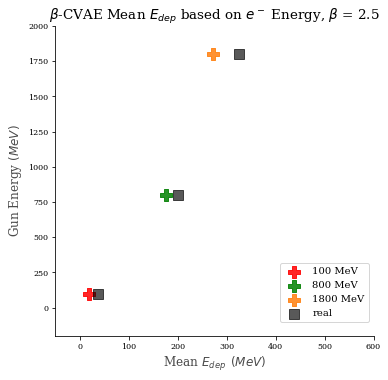

Train Epoch: 116 [0/50000 (0%)]	Loss: 191.593469
Train Epoch: 116 [5000/50000 (10%)]	Loss: 148.445264
Train Epoch: 116 [10000/50000 (20%)]	Loss: 182.644629
Train Epoch: 116 [15000/50000 (30%)]	Loss: 159.707007
Train Epoch: 116 [20000/50000 (40%)]	Loss: 171.412793
Train Epoch: 116 [25000/50000 (50%)]	Loss: 221.801221
Train Epoch: 116 [30000/50000 (60%)]	Loss: 177.139893
Train Epoch: 116 [35000/50000 (70%)]	Loss: 167.032446
Train Epoch: 116 [40000/50000 (80%)]	Loss: 189.560693
Train Epoch: 116 [45000/50000 (90%)]	Loss: 191.673364
====> Epoch: 116 Average loss: 180.9939
====> Test set loss: 187.3484
(325.5882891382654, 270.84387)


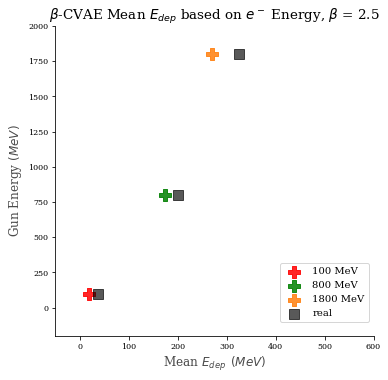

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.10037804, 14.413344)
(-0.15334117, 45.417023)
(-0.14121144, 26.437794)
(-0.036020618, 15.406709)
(-0.053583782, 44.657993)


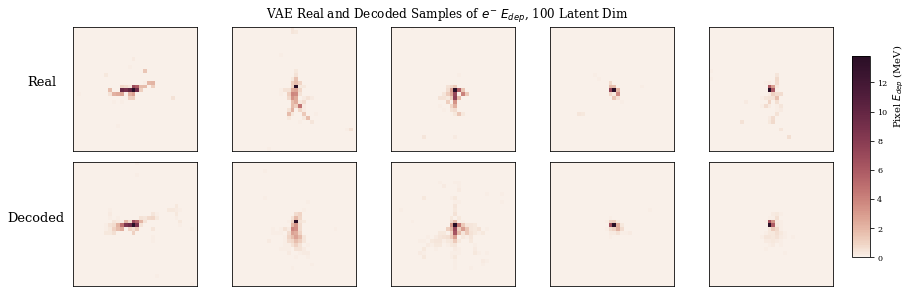

21.742641


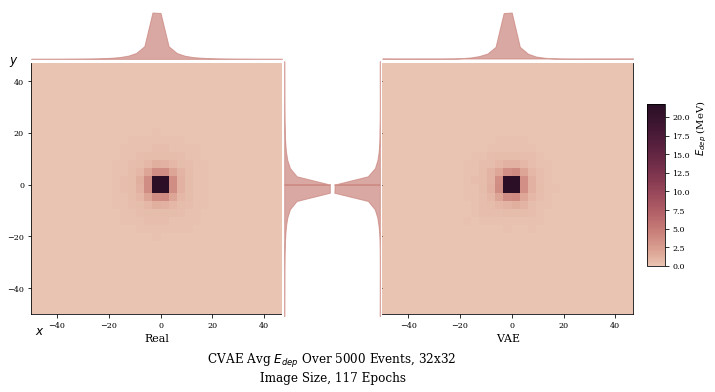

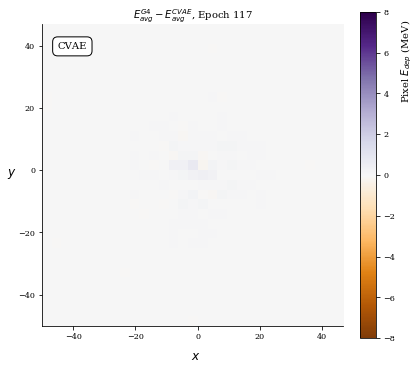

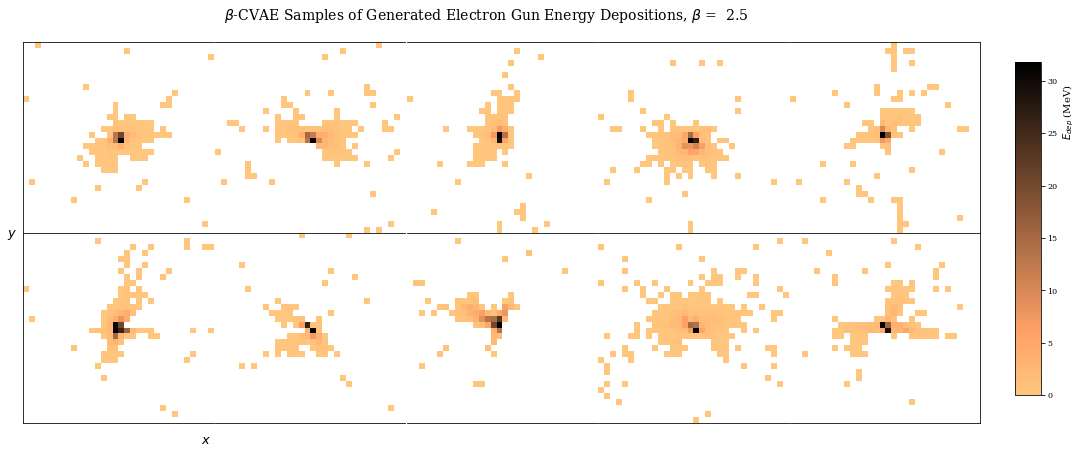

Train Epoch: 117 [0/50000 (0%)]	Loss: 188.989709
Train Epoch: 117 [5000/50000 (10%)]	Loss: 152.025000
Train Epoch: 117 [10000/50000 (20%)]	Loss: 180.568311
Train Epoch: 117 [15000/50000 (30%)]	Loss: 149.065088
Train Epoch: 117 [20000/50000 (40%)]	Loss: 174.332739
Train Epoch: 117 [25000/50000 (50%)]	Loss: 222.671973
Train Epoch: 117 [30000/50000 (60%)]	Loss: 174.792065
Train Epoch: 117 [35000/50000 (70%)]	Loss: 168.931763
Train Epoch: 117 [40000/50000 (80%)]	Loss: 194.373572
Train Epoch: 117 [45000/50000 (90%)]	Loss: 197.604272
====> Epoch: 117 Average loss: 180.7436
====> Test set loss: 188.2574
(325.5882891382654, 271.77896)


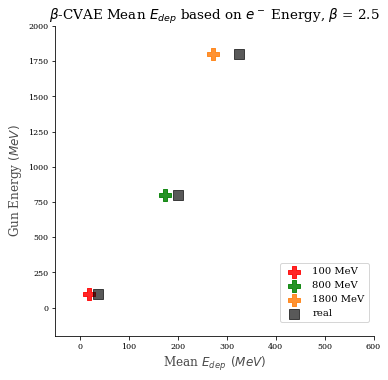

Train Epoch: 118 [0/50000 (0%)]	Loss: 193.428809
Train Epoch: 118 [5000/50000 (10%)]	Loss: 145.151929
Train Epoch: 118 [10000/50000 (20%)]	Loss: 182.355835
Train Epoch: 118 [15000/50000 (30%)]	Loss: 151.874048
Train Epoch: 118 [20000/50000 (40%)]	Loss: 171.088818
Train Epoch: 118 [25000/50000 (50%)]	Loss: 222.808740
Train Epoch: 118 [30000/50000 (60%)]	Loss: 172.309045
Train Epoch: 118 [35000/50000 (70%)]	Loss: 177.047461
Train Epoch: 118 [40000/50000 (80%)]	Loss: 196.370190
Train Epoch: 118 [45000/50000 (90%)]	Loss: 188.505054
====> Epoch: 118 Average loss: 180.7213
====> Test set loss: 187.7968
(325.5882891382654, 274.77924)


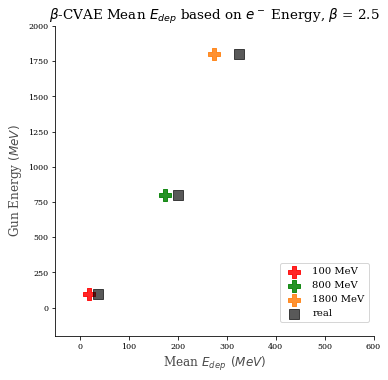

Train Epoch: 119 [0/50000 (0%)]	Loss: 192.411230
Train Epoch: 119 [5000/50000 (10%)]	Loss: 151.462500
Train Epoch: 119 [10000/50000 (20%)]	Loss: 184.788477
Train Epoch: 119 [15000/50000 (30%)]	Loss: 158.573120
Train Epoch: 119 [20000/50000 (40%)]	Loss: 172.158032
Train Epoch: 119 [25000/50000 (50%)]	Loss: 221.400757
Train Epoch: 119 [30000/50000 (60%)]	Loss: 179.066675
Train Epoch: 119 [35000/50000 (70%)]	Loss: 170.859399
Train Epoch: 119 [40000/50000 (80%)]	Loss: 199.710669
Train Epoch: 119 [45000/50000 (90%)]	Loss: 192.592578
====> Epoch: 119 Average loss: 180.6285
====> Test set loss: 185.6098
(325.5882891382654, 272.97717)


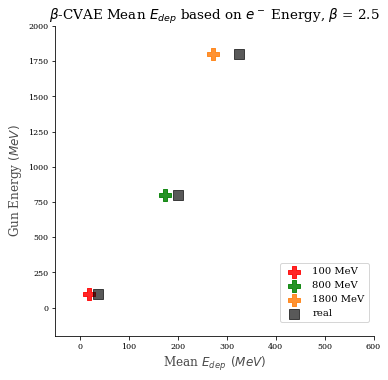

Train Epoch: 120 [0/50000 (0%)]	Loss: 192.083655
Train Epoch: 120 [5000/50000 (10%)]	Loss: 149.785547
Train Epoch: 120 [10000/50000 (20%)]	Loss: 185.199866
Train Epoch: 120 [15000/50000 (30%)]	Loss: 158.777979
Train Epoch: 120 [20000/50000 (40%)]	Loss: 178.284546
Train Epoch: 120 [25000/50000 (50%)]	Loss: 220.936377
Train Epoch: 120 [30000/50000 (60%)]	Loss: 174.263953
Train Epoch: 120 [35000/50000 (70%)]	Loss: 169.069434
Train Epoch: 120 [40000/50000 (80%)]	Loss: 192.134021
Train Epoch: 120 [45000/50000 (90%)]	Loss: 190.578149
====> Epoch: 120 Average loss: 180.3999
====> Test set loss: 186.9821
(325.5882891382654, 276.37415)


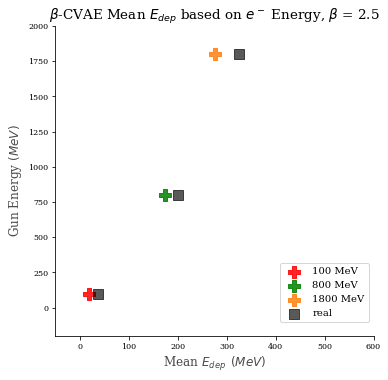

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.0998449, 14.76858)
(-0.1439287, 45.774647)
(-0.14746772, 28.734169)
(-0.038374133, 15.951835)
(-0.050485138, 47.439682)


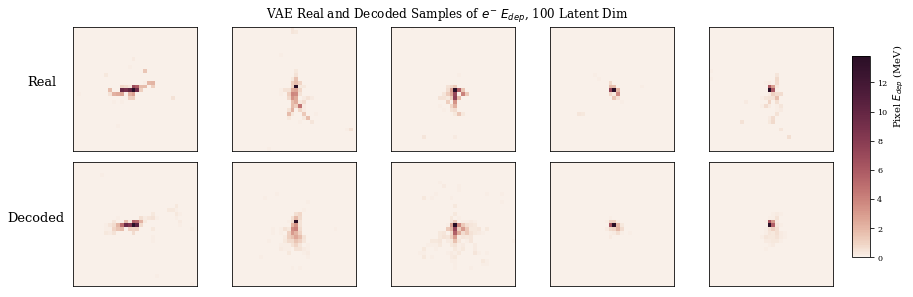

22.086678


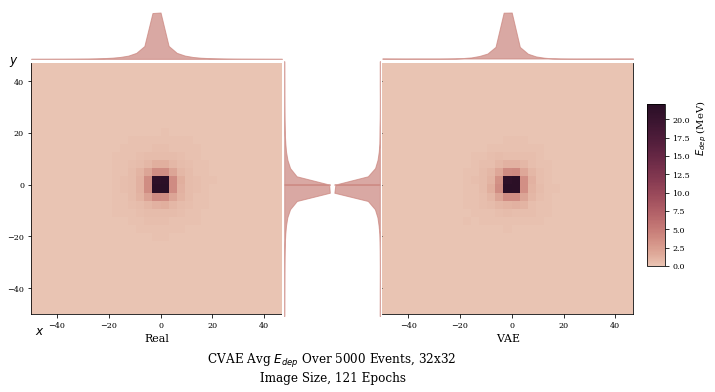

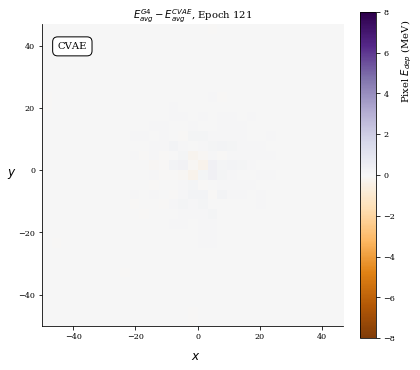

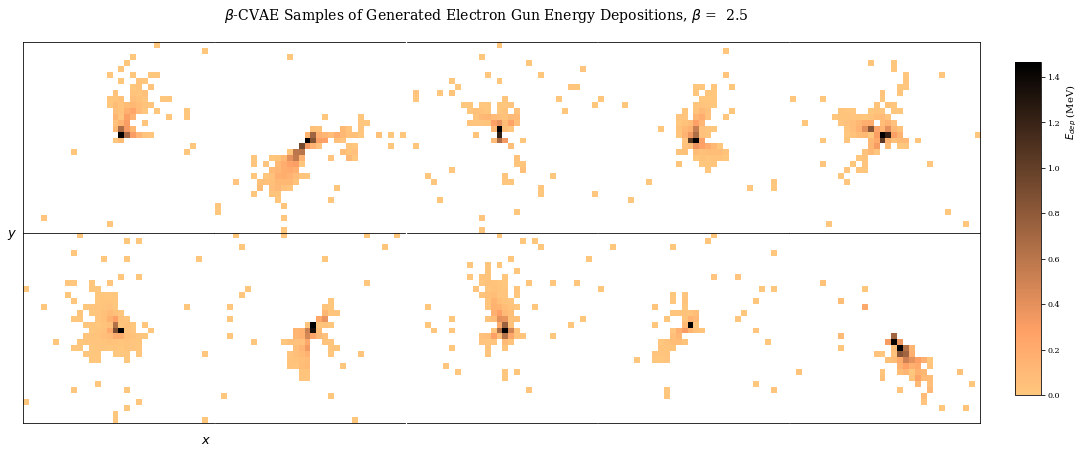

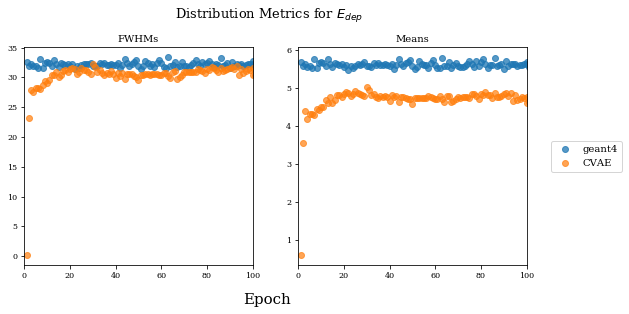

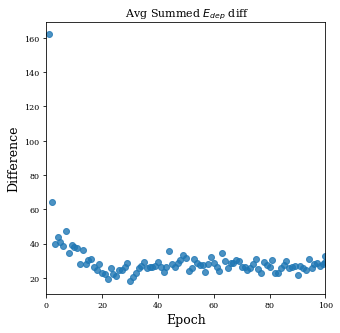

Train Epoch: 121 [0/50000 (0%)]	Loss: 193.673975
Train Epoch: 121 [5000/50000 (10%)]	Loss: 148.201367
Train Epoch: 121 [10000/50000 (20%)]	Loss: 181.466260
Train Epoch: 121 [15000/50000 (30%)]	Loss: 157.717920
Train Epoch: 121 [20000/50000 (40%)]	Loss: 170.756323
Train Epoch: 121 [25000/50000 (50%)]	Loss: 219.289697
Train Epoch: 121 [30000/50000 (60%)]	Loss: 177.358228
Train Epoch: 121 [35000/50000 (70%)]	Loss: 177.338354
Train Epoch: 121 [40000/50000 (80%)]	Loss: 193.236377
Train Epoch: 121 [45000/50000 (90%)]	Loss: 189.934241
====> Epoch: 121 Average loss: 180.2718
====> Test set loss: 188.3873


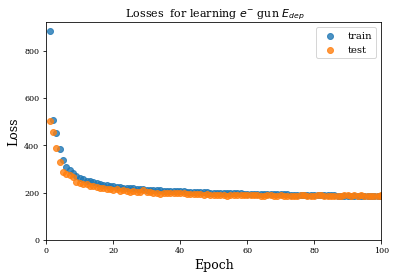

(325.5882891382654, 271.5869)


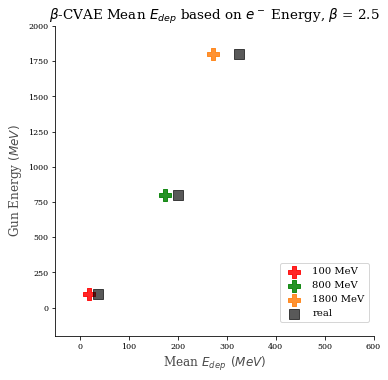

(325.5882891382654, 274.58008)


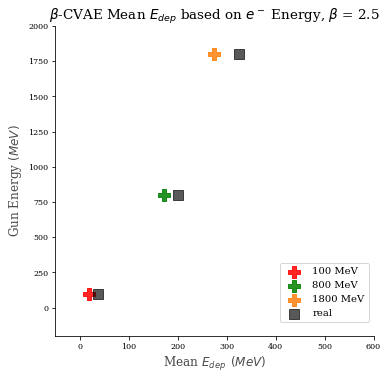

Train Epoch: 122 [0/50000 (0%)]	Loss: 196.662378
Train Epoch: 122 [5000/50000 (10%)]	Loss: 153.794824
Train Epoch: 122 [10000/50000 (20%)]	Loss: 178.794238
Train Epoch: 122 [15000/50000 (30%)]	Loss: 156.755298
Train Epoch: 122 [20000/50000 (40%)]	Loss: 181.474536
Train Epoch: 122 [25000/50000 (50%)]	Loss: 225.640088
Train Epoch: 122 [30000/50000 (60%)]	Loss: 176.654150
Train Epoch: 122 [35000/50000 (70%)]	Loss: 168.619995
Train Epoch: 122 [40000/50000 (80%)]	Loss: 191.626489
Train Epoch: 122 [45000/50000 (90%)]	Loss: 189.266785
====> Epoch: 122 Average loss: 180.0874
====> Test set loss: 188.3784
(325.5882891382654, 273.4967)


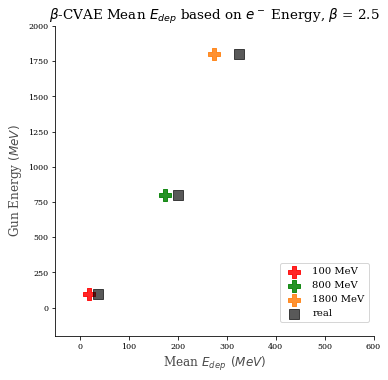

Train Epoch: 123 [0/50000 (0%)]	Loss: 189.807959
Train Epoch: 123 [5000/50000 (10%)]	Loss: 149.519702
Train Epoch: 123 [10000/50000 (20%)]	Loss: 180.928809
Train Epoch: 123 [15000/50000 (30%)]	Loss: 150.605029
Train Epoch: 123 [20000/50000 (40%)]	Loss: 173.715564
Train Epoch: 123 [25000/50000 (50%)]	Loss: 220.979761
Train Epoch: 123 [30000/50000 (60%)]	Loss: 170.679614
Train Epoch: 123 [35000/50000 (70%)]	Loss: 169.505725
Train Epoch: 123 [40000/50000 (80%)]	Loss: 195.359692
Train Epoch: 123 [45000/50000 (90%)]	Loss: 191.820215
====> Epoch: 123 Average loss: 179.8743
====> Test set loss: 188.8375
(325.5882891382654, 272.99823)


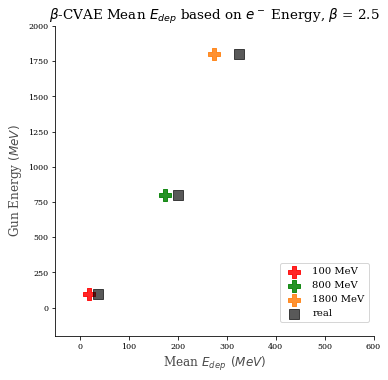

Train Epoch: 124 [0/50000 (0%)]	Loss: 193.024597
Train Epoch: 124 [5000/50000 (10%)]	Loss: 152.092432
Train Epoch: 124 [10000/50000 (20%)]	Loss: 185.160217
Train Epoch: 124 [15000/50000 (30%)]	Loss: 150.940820
Train Epoch: 124 [20000/50000 (40%)]	Loss: 177.397192
Train Epoch: 124 [25000/50000 (50%)]	Loss: 223.396436
Train Epoch: 124 [30000/50000 (60%)]	Loss: 177.250244
Train Epoch: 124 [35000/50000 (70%)]	Loss: 173.499438
Train Epoch: 124 [40000/50000 (80%)]	Loss: 189.461011
Train Epoch: 124 [45000/50000 (90%)]	Loss: 193.575464
====> Epoch: 124 Average loss: 179.6103
====> Test set loss: 186.9125
(325.5882891382654, 274.1382)


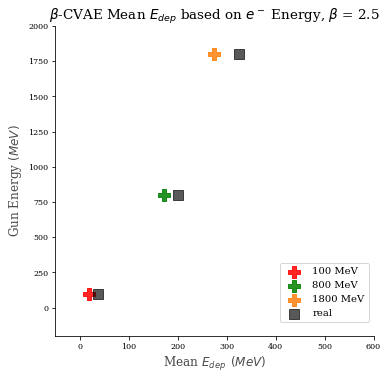

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.09066192, 15.335333)
(-0.15505001, 45.924904)
(-0.15127704, 28.32504)
(-0.03501277, 16.14008)
(-0.053402565, 46.18027)


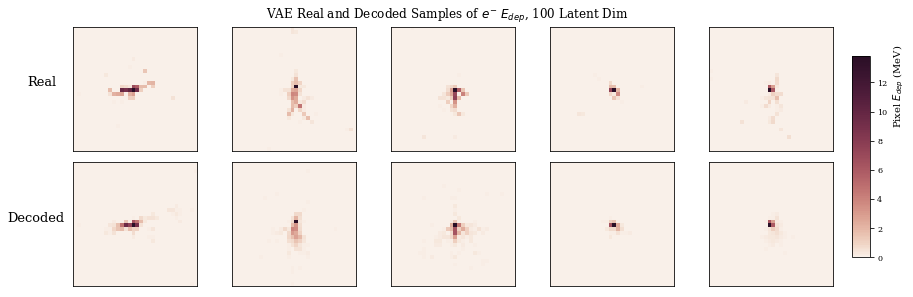

21.100483


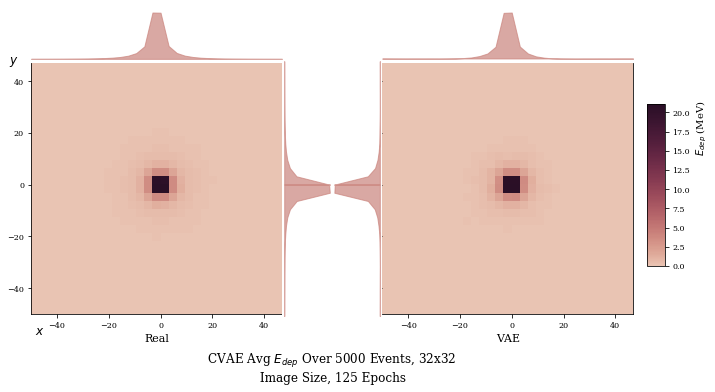

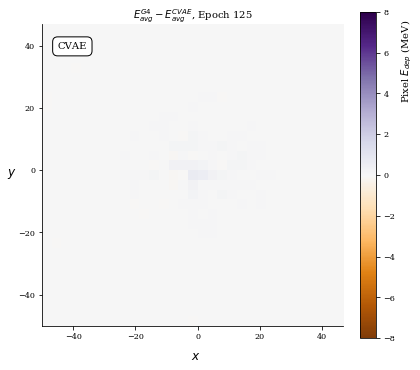

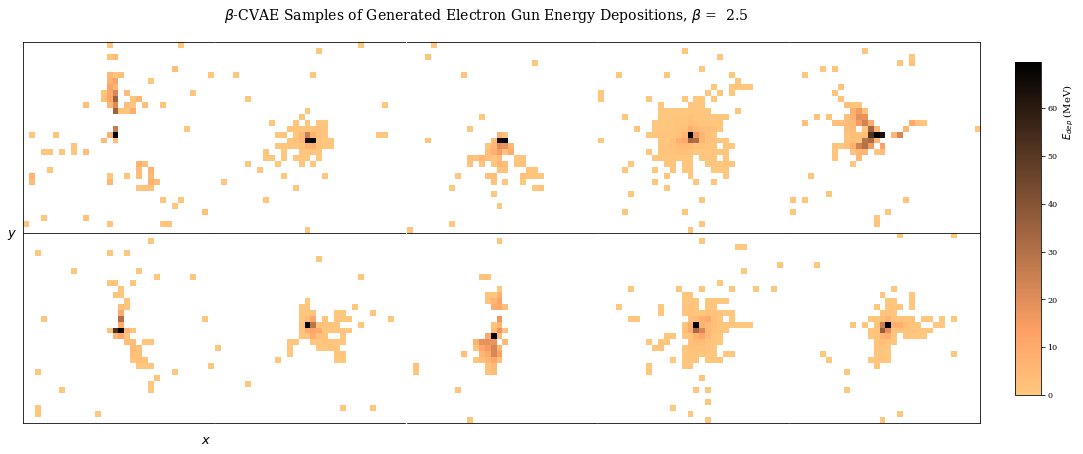

Train Epoch: 125 [0/50000 (0%)]	Loss: 196.311304
Train Epoch: 125 [5000/50000 (10%)]	Loss: 153.592139
Train Epoch: 125 [10000/50000 (20%)]	Loss: 179.600757
Train Epoch: 125 [15000/50000 (30%)]	Loss: 154.536011
Train Epoch: 125 [20000/50000 (40%)]	Loss: 175.534888
Train Epoch: 125 [25000/50000 (50%)]	Loss: 222.733862
Train Epoch: 125 [30000/50000 (60%)]	Loss: 175.077527
Train Epoch: 125 [35000/50000 (70%)]	Loss: 165.995923
Train Epoch: 125 [40000/50000 (80%)]	Loss: 195.690857
Train Epoch: 125 [45000/50000 (90%)]	Loss: 190.999072
====> Epoch: 125 Average loss: 179.6335
====> Test set loss: 187.8224
(325.5882891382654, 267.81702)


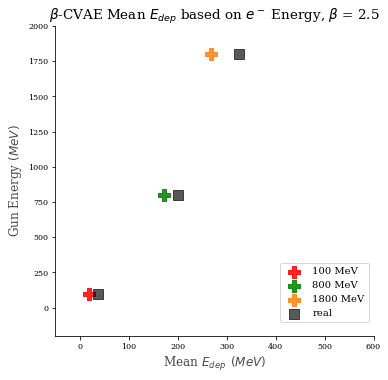

Train Epoch: 126 [0/50000 (0%)]	Loss: 189.174207
Train Epoch: 126 [5000/50000 (10%)]	Loss: 149.889160
Train Epoch: 126 [10000/50000 (20%)]	Loss: 181.153992
Train Epoch: 126 [15000/50000 (30%)]	Loss: 152.941565
Train Epoch: 126 [20000/50000 (40%)]	Loss: 174.261743
Train Epoch: 126 [25000/50000 (50%)]	Loss: 222.783667
Train Epoch: 126 [30000/50000 (60%)]	Loss: 170.695410
Train Epoch: 126 [35000/50000 (70%)]	Loss: 174.001746
Train Epoch: 126 [40000/50000 (80%)]	Loss: 189.631006
Train Epoch: 126 [45000/50000 (90%)]	Loss: 189.643604
====> Epoch: 126 Average loss: 179.5406
====> Test set loss: 187.5634
(325.5882891382654, 273.3896)


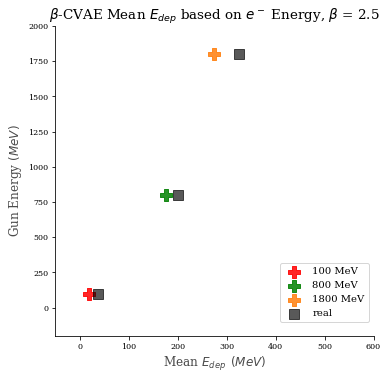

Train Epoch: 127 [0/50000 (0%)]	Loss: 195.301465
Train Epoch: 127 [5000/50000 (10%)]	Loss: 153.067163
Train Epoch: 127 [10000/50000 (20%)]	Loss: 183.245435
Train Epoch: 127 [15000/50000 (30%)]	Loss: 155.453418
Train Epoch: 127 [20000/50000 (40%)]	Loss: 177.747729
Train Epoch: 127 [25000/50000 (50%)]	Loss: 223.882373
Train Epoch: 127 [30000/50000 (60%)]	Loss: 174.320093
Train Epoch: 127 [35000/50000 (70%)]	Loss: 173.464038
Train Epoch: 127 [40000/50000 (80%)]	Loss: 187.433154
Train Epoch: 127 [45000/50000 (90%)]	Loss: 190.875879
====> Epoch: 127 Average loss: 179.2143
====> Test set loss: 188.2454
(325.5882891382654, 274.52417)


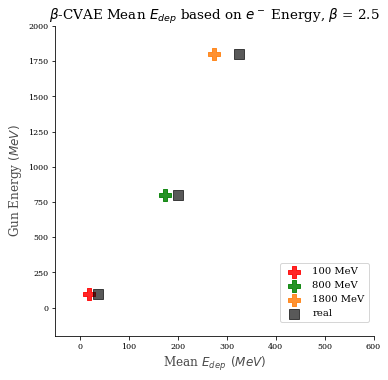

Train Epoch: 128 [0/50000 (0%)]	Loss: 189.803418
Train Epoch: 128 [5000/50000 (10%)]	Loss: 148.554736
Train Epoch: 128 [10000/50000 (20%)]	Loss: 183.609424
Train Epoch: 128 [15000/50000 (30%)]	Loss: 151.528699
Train Epoch: 128 [20000/50000 (40%)]	Loss: 170.913708
Train Epoch: 128 [25000/50000 (50%)]	Loss: 226.398706
Train Epoch: 128 [30000/50000 (60%)]	Loss: 175.547925
Train Epoch: 128 [35000/50000 (70%)]	Loss: 166.001392
Train Epoch: 128 [40000/50000 (80%)]	Loss: 193.639209
Train Epoch: 128 [45000/50000 (90%)]	Loss: 189.068091
====> Epoch: 128 Average loss: 179.2656
====> Test set loss: 189.0668
(325.5882891382654, 271.3178)


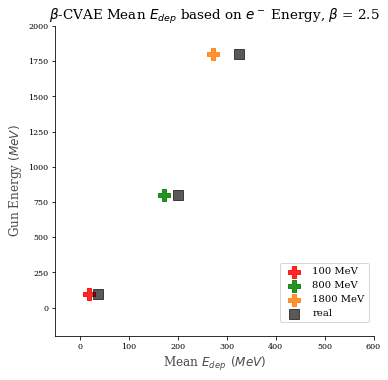

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.098140284, 14.063581)
(-0.15514956, 44.873486)
(-0.1406706, 28.09521)
(-0.037099656, 15.8323555)
(-0.052707825, 46.049248)


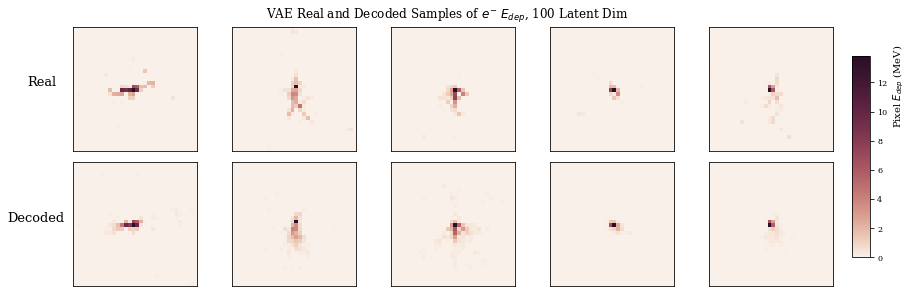

21.787113


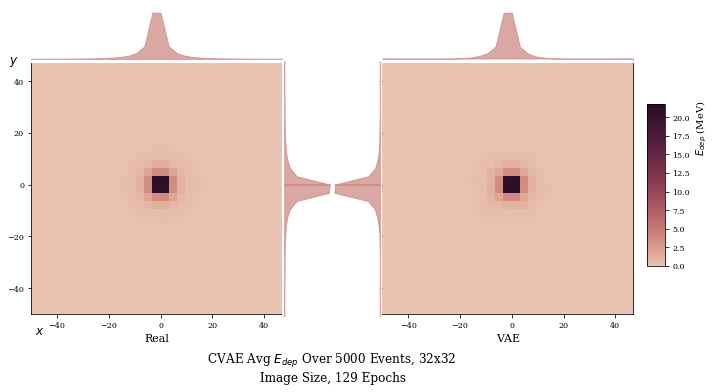

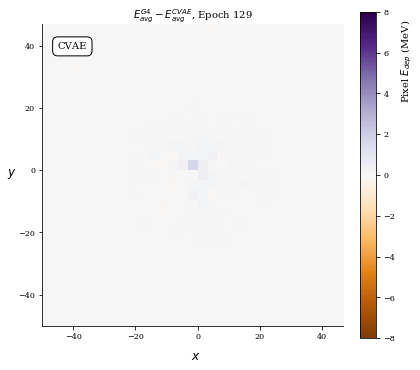

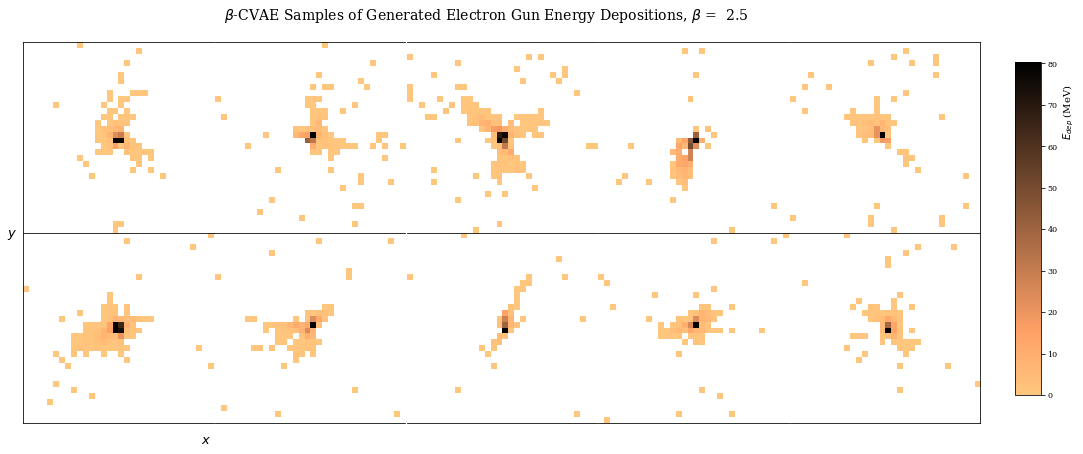

Train Epoch: 129 [0/50000 (0%)]	Loss: 192.603833
Train Epoch: 129 [5000/50000 (10%)]	Loss: 152.350098
Train Epoch: 129 [10000/50000 (20%)]	Loss: 177.030847
Train Epoch: 129 [15000/50000 (30%)]	Loss: 152.742517
Train Epoch: 129 [20000/50000 (40%)]	Loss: 173.542114
Train Epoch: 129 [25000/50000 (50%)]	Loss: 224.008984
Train Epoch: 129 [30000/50000 (60%)]	Loss: 169.488916
Train Epoch: 129 [35000/50000 (70%)]	Loss: 168.015381
Train Epoch: 129 [40000/50000 (80%)]	Loss: 189.996558
Train Epoch: 129 [45000/50000 (90%)]	Loss: 191.356250
====> Epoch: 129 Average loss: 178.9968
====> Test set loss: 188.6175
(325.5882891382654, 270.9715)


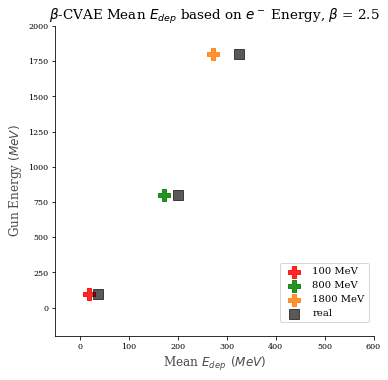

Train Epoch: 130 [0/50000 (0%)]	Loss: 189.303198
Train Epoch: 130 [5000/50000 (10%)]	Loss: 151.440991
Train Epoch: 130 [10000/50000 (20%)]	Loss: 184.074609
Train Epoch: 130 [15000/50000 (30%)]	Loss: 156.245825
Train Epoch: 130 [20000/50000 (40%)]	Loss: 169.525366
Train Epoch: 130 [25000/50000 (50%)]	Loss: 223.246436
Train Epoch: 130 [30000/50000 (60%)]	Loss: 175.574255
Train Epoch: 130 [35000/50000 (70%)]	Loss: 169.911108
Train Epoch: 130 [40000/50000 (80%)]	Loss: 189.651550
Train Epoch: 130 [45000/50000 (90%)]	Loss: 188.620337
====> Epoch: 130 Average loss: 178.7168
====> Test set loss: 188.5122
(325.5882891382654, 272.5393)


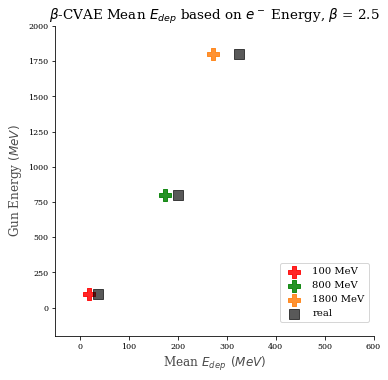

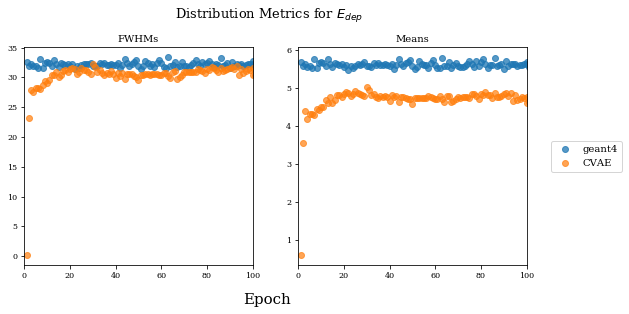

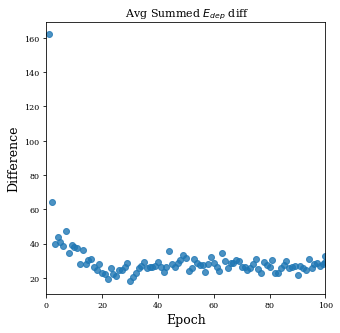

Train Epoch: 131 [0/50000 (0%)]	Loss: 189.746643
Train Epoch: 131 [5000/50000 (10%)]	Loss: 147.184229
Train Epoch: 131 [10000/50000 (20%)]	Loss: 179.537158
Train Epoch: 131 [15000/50000 (30%)]	Loss: 153.092603
Train Epoch: 131 [20000/50000 (40%)]	Loss: 174.876807
Train Epoch: 131 [25000/50000 (50%)]	Loss: 220.582910
Train Epoch: 131 [30000/50000 (60%)]	Loss: 172.095105
Train Epoch: 131 [35000/50000 (70%)]	Loss: 170.571021
Train Epoch: 131 [40000/50000 (80%)]	Loss: 194.630225
Train Epoch: 131 [45000/50000 (90%)]	Loss: 189.187537
====> Epoch: 131 Average loss: 178.6646
====> Test set loss: 189.0834


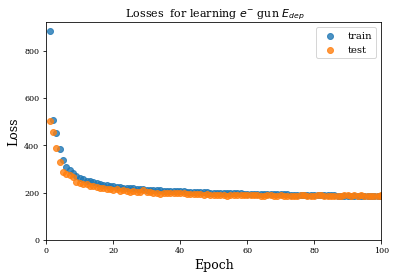

(325.5882891382654, 272.60065)


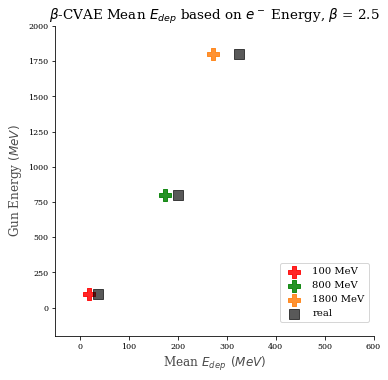

(325.5882891382654, 274.2754)


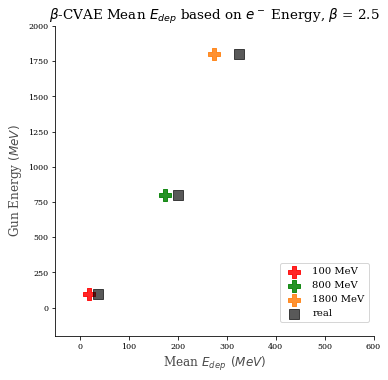

Train Epoch: 132 [0/50000 (0%)]	Loss: 189.329834
Train Epoch: 132 [5000/50000 (10%)]	Loss: 149.306006
Train Epoch: 132 [10000/50000 (20%)]	Loss: 177.865381
Train Epoch: 132 [15000/50000 (30%)]	Loss: 151.026379
Train Epoch: 132 [20000/50000 (40%)]	Loss: 170.318250
Train Epoch: 132 [25000/50000 (50%)]	Loss: 218.072900
Train Epoch: 132 [30000/50000 (60%)]	Loss: 172.977344
Train Epoch: 132 [35000/50000 (70%)]	Loss: 167.779395
Train Epoch: 132 [40000/50000 (80%)]	Loss: 194.276855
Train Epoch: 132 [45000/50000 (90%)]	Loss: 194.815515
====> Epoch: 132 Average loss: 178.6275
====> Test set loss: 187.7664
(325.5882891382654, 271.38544)


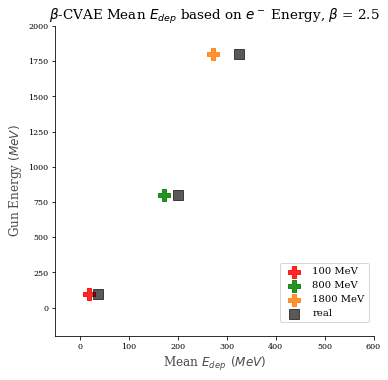

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.09581125, 14.127325)
(-0.15369286, 46.52286)
(-0.13865057, 28.204378)
(-0.036481064, 15.332879)
(-0.054257948, 46.18486)


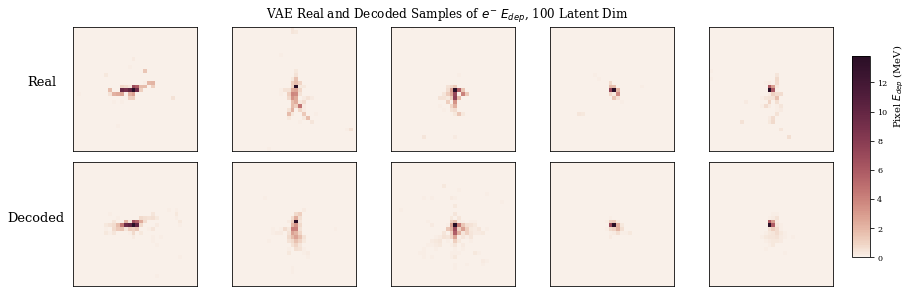

22.164328


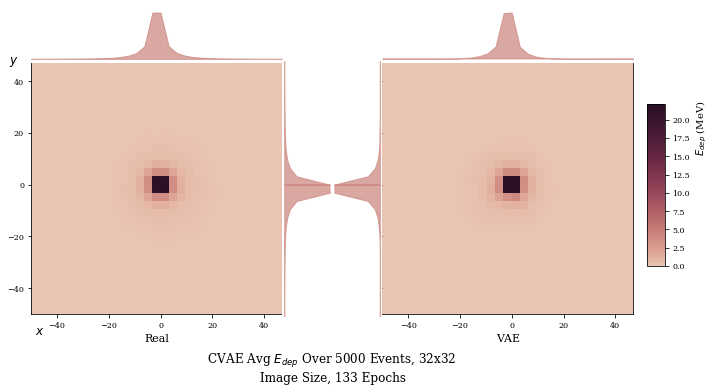

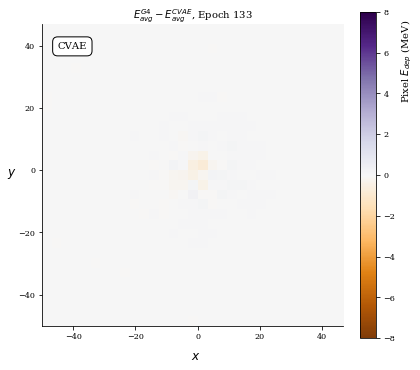

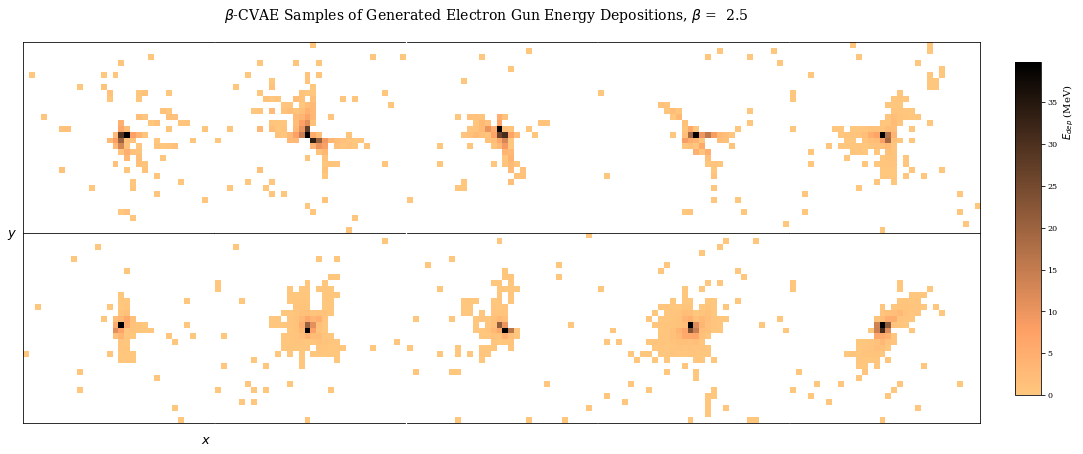

Train Epoch: 133 [0/50000 (0%)]	Loss: 189.276440
Train Epoch: 133 [5000/50000 (10%)]	Loss: 154.997095
Train Epoch: 133 [10000/50000 (20%)]	Loss: 180.371326
Train Epoch: 133 [15000/50000 (30%)]	Loss: 151.370691
Train Epoch: 133 [20000/50000 (40%)]	Loss: 176.408484
Train Epoch: 133 [25000/50000 (50%)]	Loss: 222.473730
Train Epoch: 133 [30000/50000 (60%)]	Loss: 174.729443
Train Epoch: 133 [35000/50000 (70%)]	Loss: 168.920312
Train Epoch: 133 [40000/50000 (80%)]	Loss: 190.580798
Train Epoch: 133 [45000/50000 (90%)]	Loss: 189.876392
====> Epoch: 133 Average loss: 178.2468
====> Test set loss: 188.4910
(325.5882891382654, 267.32602)


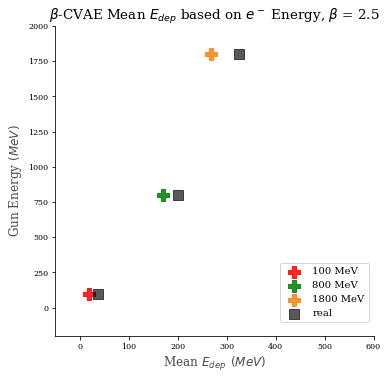

Train Epoch: 134 [0/50000 (0%)]	Loss: 188.726013
Train Epoch: 134 [5000/50000 (10%)]	Loss: 152.687793
Train Epoch: 134 [10000/50000 (20%)]	Loss: 182.893396
Train Epoch: 134 [15000/50000 (30%)]	Loss: 154.587451
Train Epoch: 134 [20000/50000 (40%)]	Loss: 173.510889
Train Epoch: 134 [25000/50000 (50%)]	Loss: 217.331226
Train Epoch: 134 [30000/50000 (60%)]	Loss: 175.848108
Train Epoch: 134 [35000/50000 (70%)]	Loss: 161.392554
Train Epoch: 134 [40000/50000 (80%)]	Loss: 188.072229
Train Epoch: 134 [45000/50000 (90%)]	Loss: 196.449170
====> Epoch: 134 Average loss: 178.1226
====> Test set loss: 187.8983
(325.5882891382654, 272.85934)


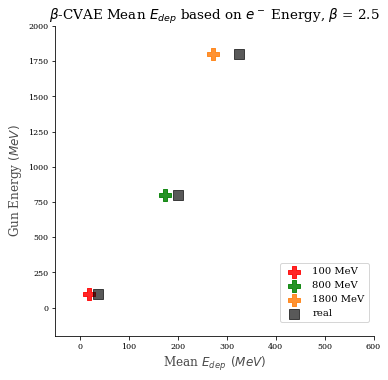

Train Epoch: 135 [0/50000 (0%)]	Loss: 189.293970
Train Epoch: 135 [5000/50000 (10%)]	Loss: 148.710986
Train Epoch: 135 [10000/50000 (20%)]	Loss: 178.729321
Train Epoch: 135 [15000/50000 (30%)]	Loss: 149.596826
Train Epoch: 135 [20000/50000 (40%)]	Loss: 176.239819
Train Epoch: 135 [25000/50000 (50%)]	Loss: 222.777051
Train Epoch: 135 [30000/50000 (60%)]	Loss: 173.174231
Train Epoch: 135 [35000/50000 (70%)]	Loss: 164.181519
Train Epoch: 135 [40000/50000 (80%)]	Loss: 191.557703
Train Epoch: 135 [45000/50000 (90%)]	Loss: 188.534619
====> Epoch: 135 Average loss: 177.9141
====> Test set loss: 187.9508
(325.5882891382654, 271.38544)


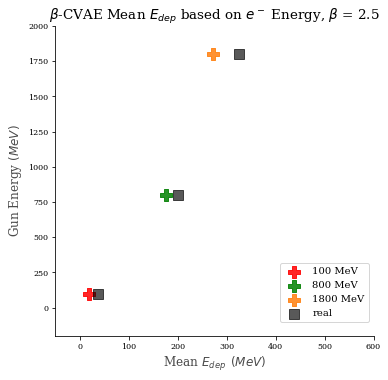

Train Epoch: 136 [0/50000 (0%)]	Loss: 188.671216
Train Epoch: 136 [5000/50000 (10%)]	Loss: 145.982349
Train Epoch: 136 [10000/50000 (20%)]	Loss: 176.645166
Train Epoch: 136 [15000/50000 (30%)]	Loss: 148.760449
Train Epoch: 136 [20000/50000 (40%)]	Loss: 173.433374
Train Epoch: 136 [25000/50000 (50%)]	Loss: 218.009180
Train Epoch: 136 [30000/50000 (60%)]	Loss: 178.335205
Train Epoch: 136 [35000/50000 (70%)]	Loss: 168.921875
Train Epoch: 136 [40000/50000 (80%)]	Loss: 196.921045
Train Epoch: 136 [45000/50000 (90%)]	Loss: 189.987500
====> Epoch: 136 Average loss: 177.8612
====> Test set loss: 187.7132
(325.5882891382654, 272.31818)


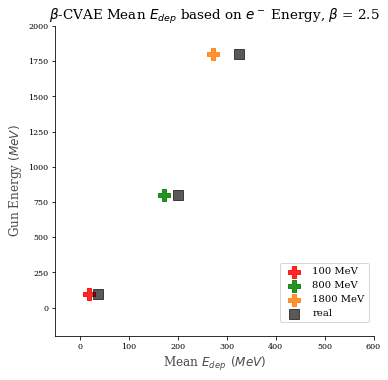

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.09787689, 14.235573)
(-0.18280019, 47.544415)
(-0.17617378, 28.037432)
(-0.039053135, 15.804367)
(-0.052988164, 45.818443)


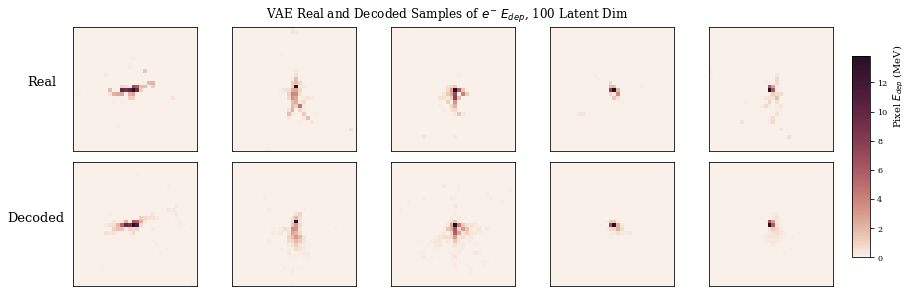

21.442083


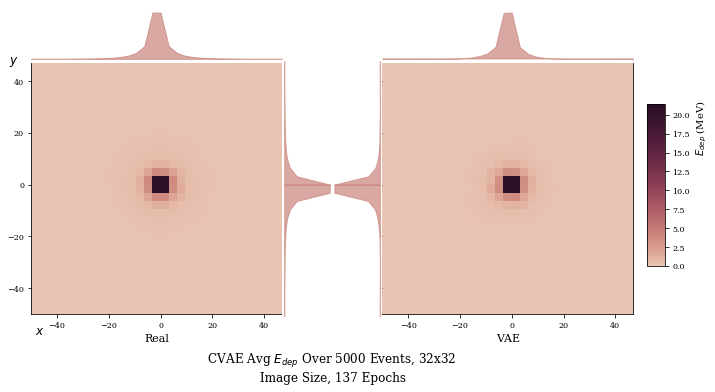

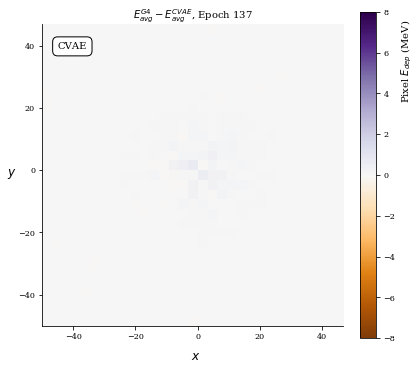

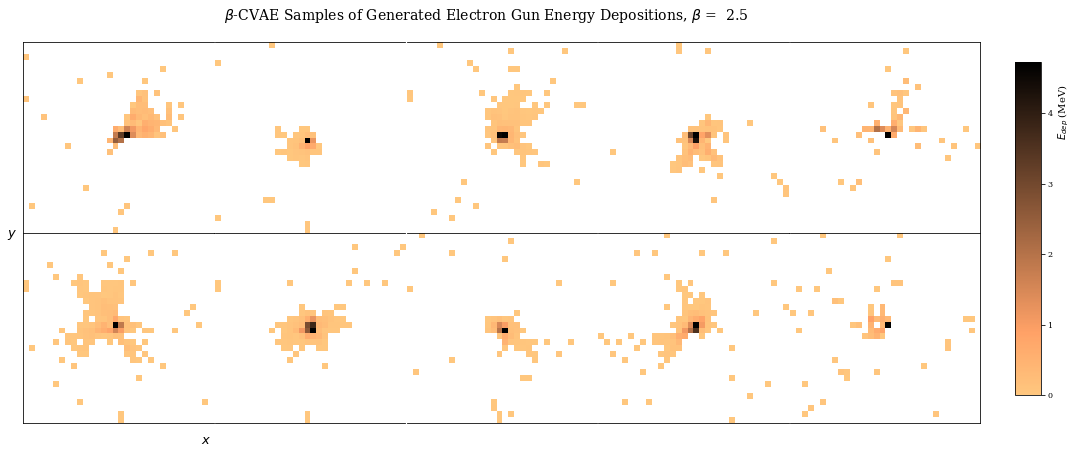

Train Epoch: 137 [0/50000 (0%)]	Loss: 188.600977
Train Epoch: 137 [5000/50000 (10%)]	Loss: 147.996875
Train Epoch: 137 [10000/50000 (20%)]	Loss: 177.802124
Train Epoch: 137 [15000/50000 (30%)]	Loss: 153.247510
Train Epoch: 137 [20000/50000 (40%)]	Loss: 169.178406
Train Epoch: 137 [25000/50000 (50%)]	Loss: 220.170117
Train Epoch: 137 [30000/50000 (60%)]	Loss: 172.744141
Train Epoch: 137 [35000/50000 (70%)]	Loss: 173.258594
Train Epoch: 137 [40000/50000 (80%)]	Loss: 191.531787
Train Epoch: 137 [45000/50000 (90%)]	Loss: 190.546509
====> Epoch: 137 Average loss: 177.6421
====> Test set loss: 191.3534
(325.5882891382654, 271.75223)


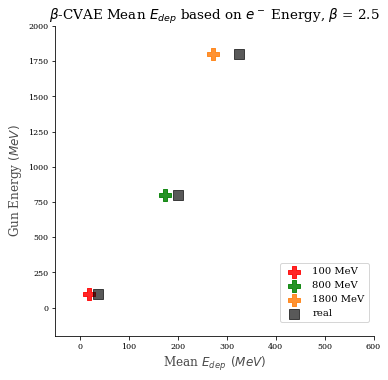

Train Epoch: 138 [0/50000 (0%)]	Loss: 185.075586
Train Epoch: 138 [5000/50000 (10%)]	Loss: 148.118384
Train Epoch: 138 [10000/50000 (20%)]	Loss: 177.960522
Train Epoch: 138 [15000/50000 (30%)]	Loss: 150.290186
Train Epoch: 138 [20000/50000 (40%)]	Loss: 172.793994
Train Epoch: 138 [25000/50000 (50%)]	Loss: 216.277539
Train Epoch: 138 [30000/50000 (60%)]	Loss: 170.148767
Train Epoch: 138 [35000/50000 (70%)]	Loss: 166.019507
Train Epoch: 138 [40000/50000 (80%)]	Loss: 196.413843
Train Epoch: 138 [45000/50000 (90%)]	Loss: 187.705371
====> Epoch: 138 Average loss: 177.6375
====> Test set loss: 187.4194
(325.5882891382654, 270.5358)


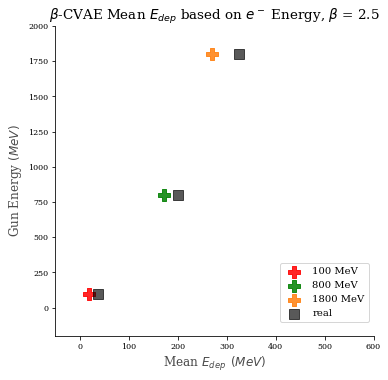

Train Epoch: 139 [0/50000 (0%)]	Loss: 191.708008
Train Epoch: 139 [5000/50000 (10%)]	Loss: 152.600391
Train Epoch: 139 [10000/50000 (20%)]	Loss: 179.582336
Train Epoch: 139 [15000/50000 (30%)]	Loss: 150.360645
Train Epoch: 139 [20000/50000 (40%)]	Loss: 176.643018
Train Epoch: 139 [25000/50000 (50%)]	Loss: 221.935596
Train Epoch: 139 [30000/50000 (60%)]	Loss: 172.264319
Train Epoch: 139 [35000/50000 (70%)]	Loss: 166.219629
Train Epoch: 139 [40000/50000 (80%)]	Loss: 188.409985
Train Epoch: 139 [45000/50000 (90%)]	Loss: 186.714282
====> Epoch: 139 Average loss: 177.3057
====> Test set loss: 189.1756
(325.5882891382654, 271.0042)


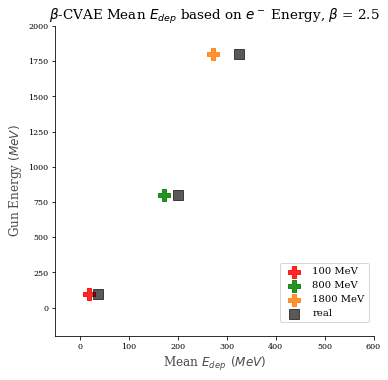

Train Epoch: 140 [0/50000 (0%)]	Loss: 186.499438
Train Epoch: 140 [5000/50000 (10%)]	Loss: 145.050610
Train Epoch: 140 [10000/50000 (20%)]	Loss: 177.711377
Train Epoch: 140 [15000/50000 (30%)]	Loss: 157.406445
Train Epoch: 140 [20000/50000 (40%)]	Loss: 171.864185
Train Epoch: 140 [25000/50000 (50%)]	Loss: 219.166528
Train Epoch: 140 [30000/50000 (60%)]	Loss: 173.543274
Train Epoch: 140 [35000/50000 (70%)]	Loss: 168.405981
Train Epoch: 140 [40000/50000 (80%)]	Loss: 186.498889
Train Epoch: 140 [45000/50000 (90%)]	Loss: 186.892114
====> Epoch: 140 Average loss: 177.2692
====> Test set loss: 191.4507
(325.5882891382654, 271.24304)


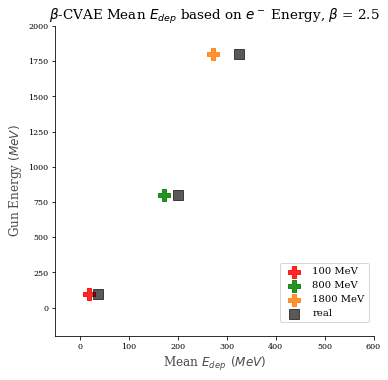

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.09902111, 15.098588)
(-0.17208171, 45.353313)
(-0.15027627, 28.431)
(-0.037076116, 16.72041)
(-0.057900675, 46.019928)


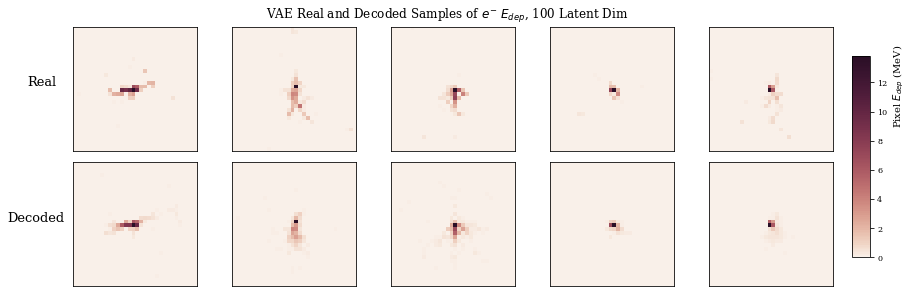

21.539501


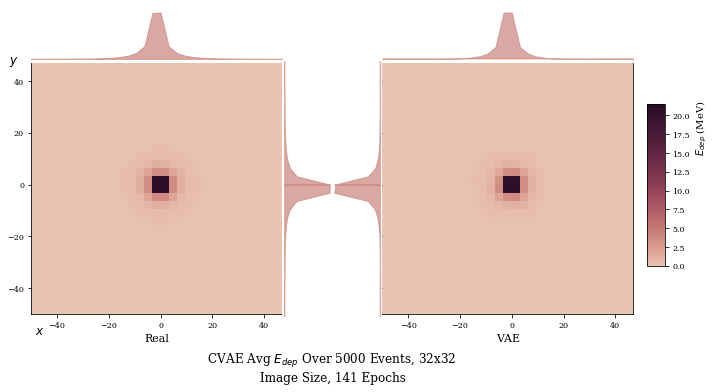

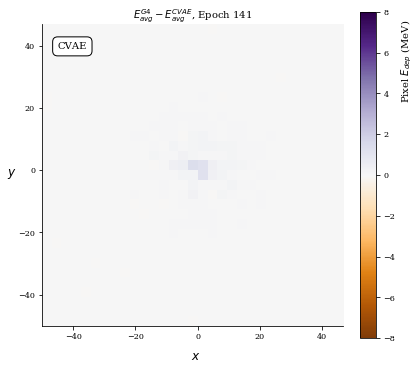

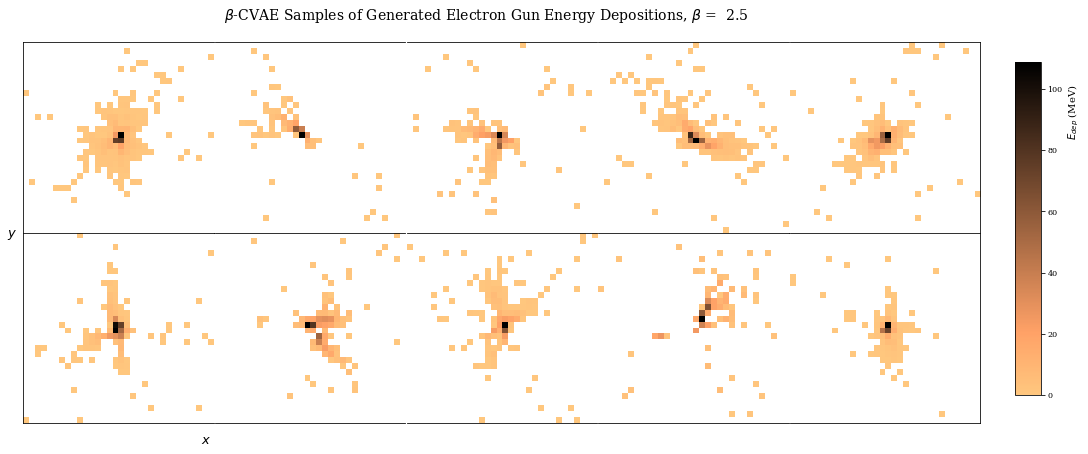

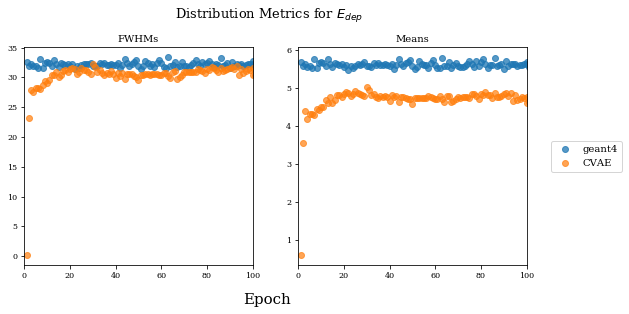

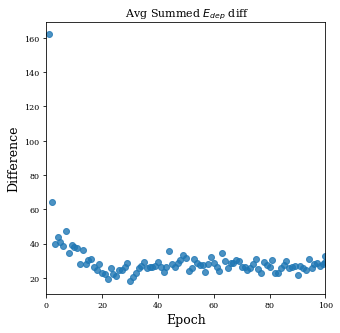

Train Epoch: 141 [0/50000 (0%)]	Loss: 192.975122
Train Epoch: 141 [5000/50000 (10%)]	Loss: 146.658752
Train Epoch: 141 [10000/50000 (20%)]	Loss: 180.659424
Train Epoch: 141 [15000/50000 (30%)]	Loss: 150.174854
Train Epoch: 141 [20000/50000 (40%)]	Loss: 168.666895
Train Epoch: 141 [25000/50000 (50%)]	Loss: 221.969141
Train Epoch: 141 [30000/50000 (60%)]	Loss: 166.619971
Train Epoch: 141 [35000/50000 (70%)]	Loss: 169.491028
Train Epoch: 141 [40000/50000 (80%)]	Loss: 190.340759
Train Epoch: 141 [45000/50000 (90%)]	Loss: 188.193188
====> Epoch: 141 Average loss: 177.0147
====> Test set loss: 190.3909


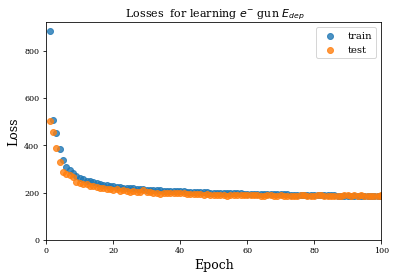

(325.5882891382654, 271.72302)


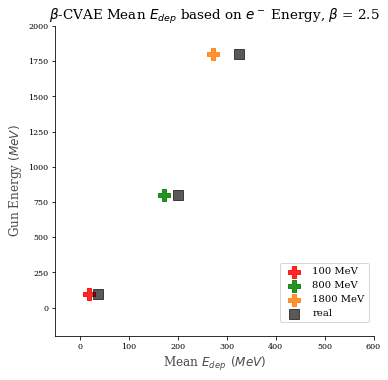

(325.5882891382654, 271.18927)


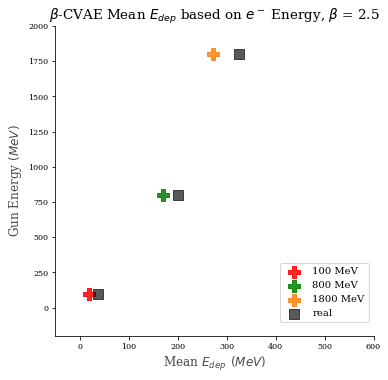

Train Epoch: 142 [0/50000 (0%)]	Loss: 189.156616
Train Epoch: 142 [5000/50000 (10%)]	Loss: 149.972778
Train Epoch: 142 [10000/50000 (20%)]	Loss: 182.456909
Train Epoch: 142 [15000/50000 (30%)]	Loss: 150.626611
Train Epoch: 142 [20000/50000 (40%)]	Loss: 173.491187
Train Epoch: 142 [25000/50000 (50%)]	Loss: 217.465283
Train Epoch: 142 [30000/50000 (60%)]	Loss: 175.891321
Train Epoch: 142 [35000/50000 (70%)]	Loss: 165.513220
Train Epoch: 142 [40000/50000 (80%)]	Loss: 191.199561
Train Epoch: 142 [45000/50000 (90%)]	Loss: 190.154651
====> Epoch: 142 Average loss: 176.8643
====> Test set loss: 190.4248
(325.5882891382654, 275.61264)


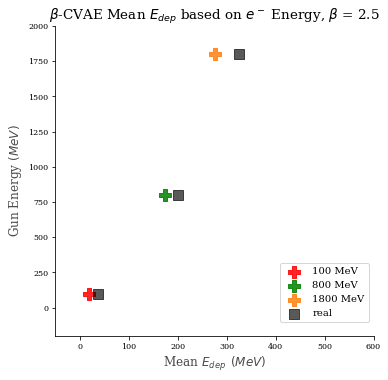

Train Epoch: 143 [0/50000 (0%)]	Loss: 194.320264
Train Epoch: 143 [5000/50000 (10%)]	Loss: 149.556567
Train Epoch: 143 [10000/50000 (20%)]	Loss: 177.688330
Train Epoch: 143 [15000/50000 (30%)]	Loss: 147.011572
Train Epoch: 143 [20000/50000 (40%)]	Loss: 169.823474
Train Epoch: 143 [25000/50000 (50%)]	Loss: 220.215332
Train Epoch: 143 [30000/50000 (60%)]	Loss: 180.119678
Train Epoch: 143 [35000/50000 (70%)]	Loss: 162.603320
Train Epoch: 143 [40000/50000 (80%)]	Loss: 183.551758
Train Epoch: 143 [45000/50000 (90%)]	Loss: 188.348267
====> Epoch: 143 Average loss: 176.7929
====> Test set loss: 189.8075
(325.5882891382654, 267.60175)


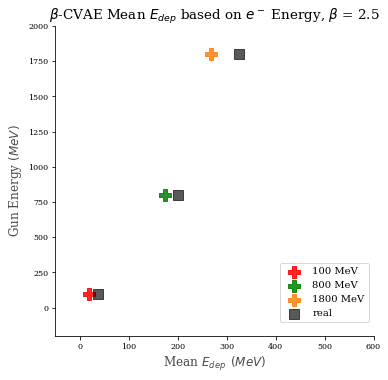

Train Epoch: 144 [0/50000 (0%)]	Loss: 189.964465
Train Epoch: 144 [5000/50000 (10%)]	Loss: 144.390491
Train Epoch: 144 [10000/50000 (20%)]	Loss: 179.225049
Train Epoch: 144 [15000/50000 (30%)]	Loss: 149.827588
Train Epoch: 144 [20000/50000 (40%)]	Loss: 174.419897
Train Epoch: 144 [25000/50000 (50%)]	Loss: 217.876416
Train Epoch: 144 [30000/50000 (60%)]	Loss: 168.443506
Train Epoch: 144 [35000/50000 (70%)]	Loss: 170.359521
Train Epoch: 144 [40000/50000 (80%)]	Loss: 188.722876
Train Epoch: 144 [45000/50000 (90%)]	Loss: 188.918152
====> Epoch: 144 Average loss: 176.4737
====> Test set loss: 190.4644
(325.5882891382654, 270.70154)


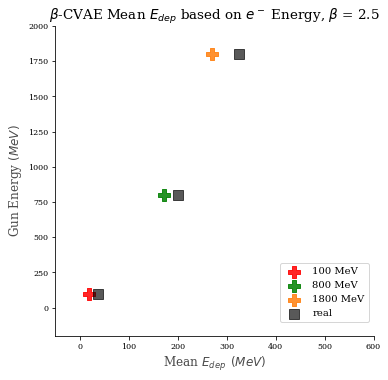

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.10493706, 15.07088)
(-0.18839349, 46.60977)
(-0.14902109, 27.788252)
(-0.03656611, 16.428082)
(-0.059349775, 45.83425)


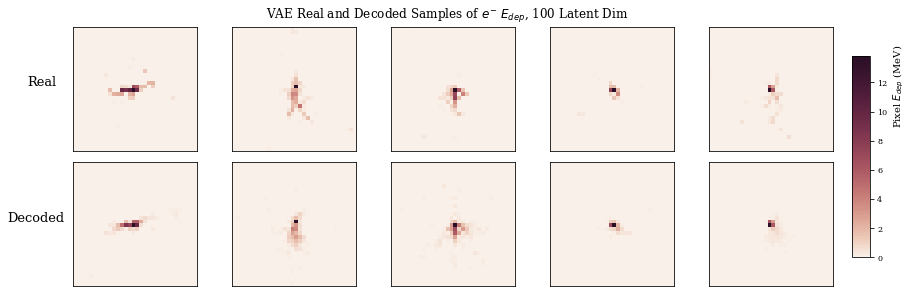

21.541637


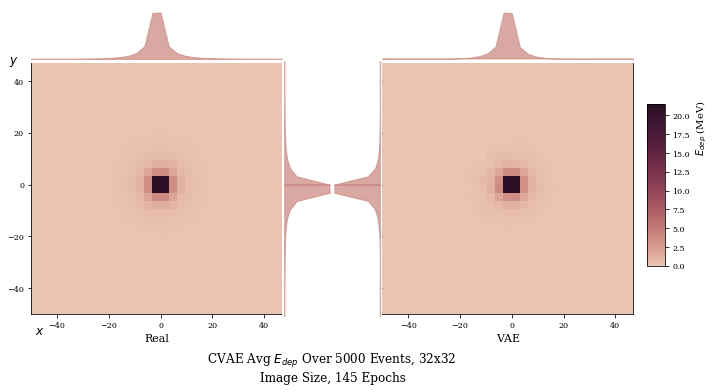

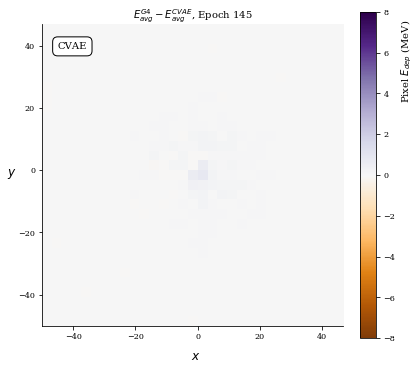

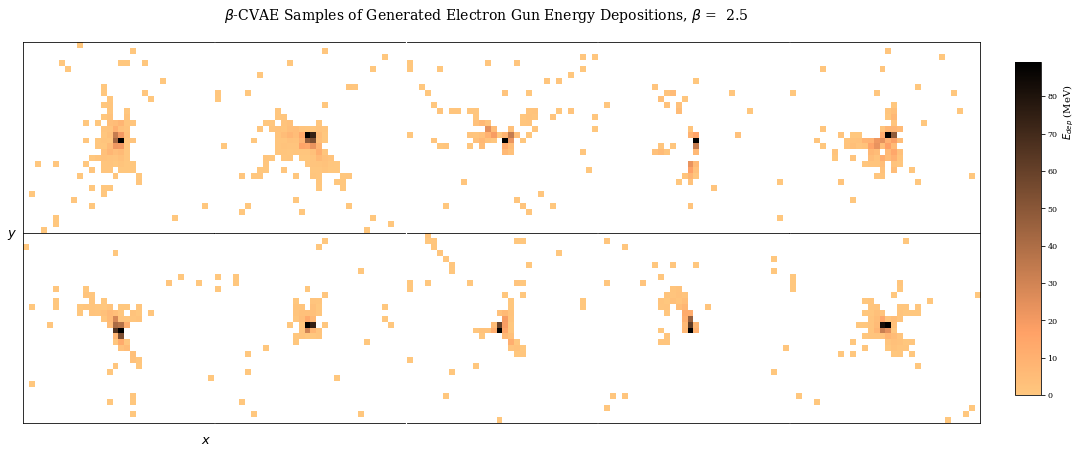

Train Epoch: 145 [0/50000 (0%)]	Loss: 188.363123
Train Epoch: 145 [5000/50000 (10%)]	Loss: 149.362573
Train Epoch: 145 [10000/50000 (20%)]	Loss: 179.830591
Train Epoch: 145 [15000/50000 (30%)]	Loss: 152.228564
Train Epoch: 145 [20000/50000 (40%)]	Loss: 173.364429
Train Epoch: 145 [25000/50000 (50%)]	Loss: 219.204517
Train Epoch: 145 [30000/50000 (60%)]	Loss: 177.928809
Train Epoch: 145 [35000/50000 (70%)]	Loss: 173.920203
Train Epoch: 145 [40000/50000 (80%)]	Loss: 197.340649
Train Epoch: 145 [45000/50000 (90%)]	Loss: 187.239795
====> Epoch: 145 Average loss: 176.4209
====> Test set loss: 190.7672
(325.5882891382654, 273.51672)


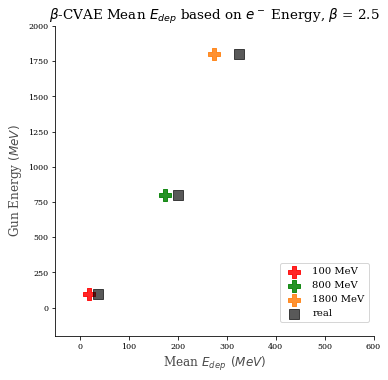

Train Epoch: 146 [0/50000 (0%)]	Loss: 187.593958
Train Epoch: 146 [5000/50000 (10%)]	Loss: 146.131506
Train Epoch: 146 [10000/50000 (20%)]	Loss: 179.519690
Train Epoch: 146 [15000/50000 (30%)]	Loss: 146.897705
Train Epoch: 146 [20000/50000 (40%)]	Loss: 169.525024
Train Epoch: 146 [25000/50000 (50%)]	Loss: 216.027783
Train Epoch: 146 [30000/50000 (60%)]	Loss: 167.001221
Train Epoch: 146 [35000/50000 (70%)]	Loss: 165.315466
Train Epoch: 146 [40000/50000 (80%)]	Loss: 188.454016
Train Epoch: 146 [45000/50000 (90%)]	Loss: 194.242554
====> Epoch: 146 Average loss: 176.3008
====> Test set loss: 188.7738
(325.5882891382654, 271.3545)


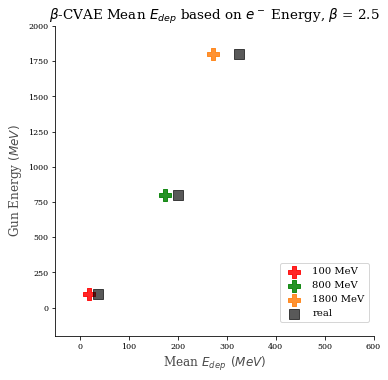

Train Epoch: 147 [0/50000 (0%)]	Loss: 185.876733
Train Epoch: 147 [5000/50000 (10%)]	Loss: 151.677832
Train Epoch: 147 [10000/50000 (20%)]	Loss: 179.414722
Train Epoch: 147 [15000/50000 (30%)]	Loss: 147.332251
Train Epoch: 147 [20000/50000 (40%)]	Loss: 171.724609
Train Epoch: 147 [25000/50000 (50%)]	Loss: 217.133154
Train Epoch: 147 [30000/50000 (60%)]	Loss: 172.166235
Train Epoch: 147 [35000/50000 (70%)]	Loss: 163.277393
Train Epoch: 147 [40000/50000 (80%)]	Loss: 186.643689
Train Epoch: 147 [45000/50000 (90%)]	Loss: 189.487537
====> Epoch: 147 Average loss: 176.0403
====> Test set loss: 191.5786
(325.5882891382654, 271.48)


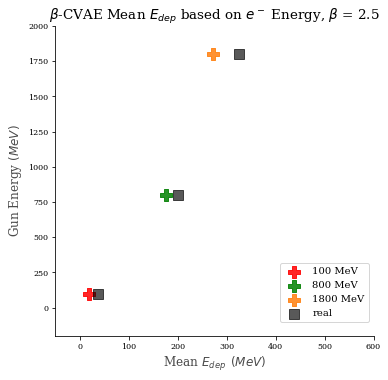

Train Epoch: 148 [0/50000 (0%)]	Loss: 188.547021
Train Epoch: 148 [5000/50000 (10%)]	Loss: 147.996606
Train Epoch: 148 [10000/50000 (20%)]	Loss: 175.917773
Train Epoch: 148 [15000/50000 (30%)]	Loss: 145.744971
Train Epoch: 148 [20000/50000 (40%)]	Loss: 173.487817
Train Epoch: 148 [25000/50000 (50%)]	Loss: 215.380835
Train Epoch: 148 [30000/50000 (60%)]	Loss: 168.740845
Train Epoch: 148 [35000/50000 (70%)]	Loss: 169.627454
Train Epoch: 148 [40000/50000 (80%)]	Loss: 185.836133
Train Epoch: 148 [45000/50000 (90%)]	Loss: 186.109949
====> Epoch: 148 Average loss: 176.0690
====> Test set loss: 190.7700
(325.5882891382654, 273.68793)


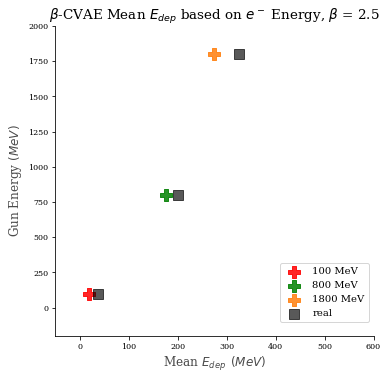

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.10011514, 15.384903)
(-0.16045305, 46.29176)
(-0.18259425, 26.524029)
(-0.035125542, 15.144268)
(-0.054173477, 46.734447)


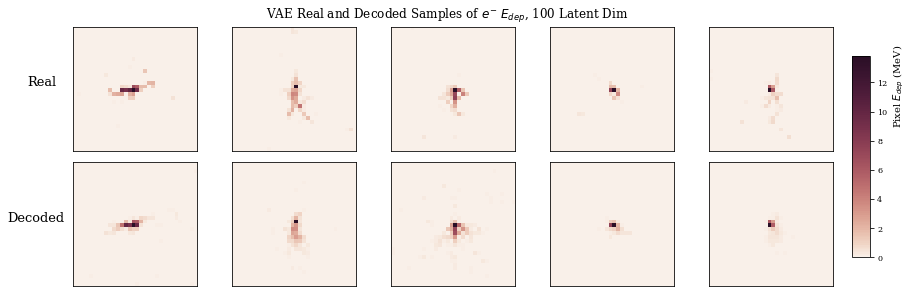

22.269495


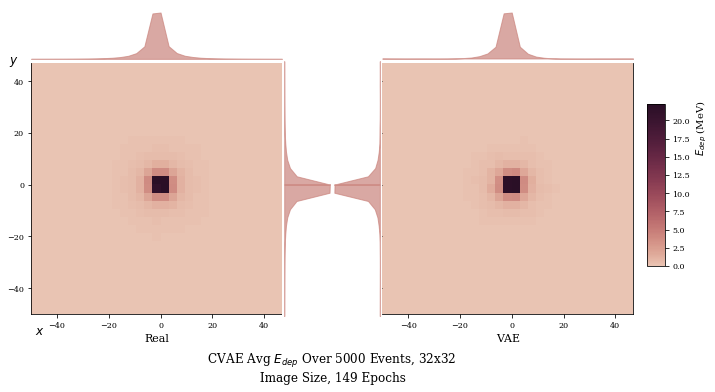

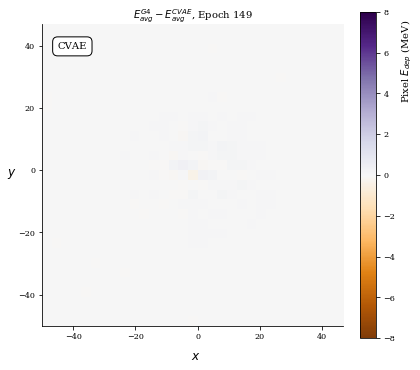

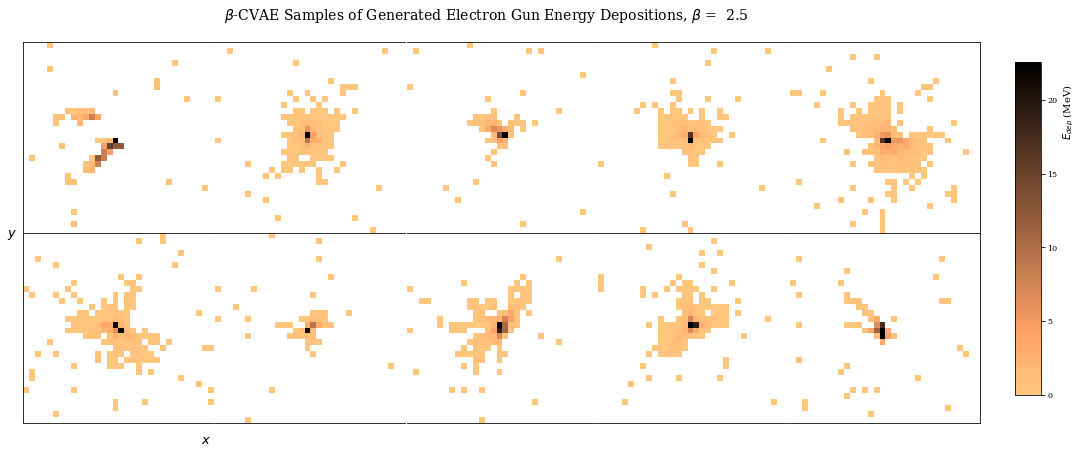

Train Epoch: 149 [0/50000 (0%)]	Loss: 187.507007
Train Epoch: 149 [5000/50000 (10%)]	Loss: 146.203113
Train Epoch: 149 [10000/50000 (20%)]	Loss: 177.445349
Train Epoch: 149 [15000/50000 (30%)]	Loss: 155.654395
Train Epoch: 149 [20000/50000 (40%)]	Loss: 174.684497
Train Epoch: 149 [25000/50000 (50%)]	Loss: 214.218213
Train Epoch: 149 [30000/50000 (60%)]	Loss: 166.782703
Train Epoch: 149 [35000/50000 (70%)]	Loss: 169.014771
Train Epoch: 149 [40000/50000 (80%)]	Loss: 190.675830
Train Epoch: 149 [45000/50000 (90%)]	Loss: 186.086011
====> Epoch: 149 Average loss: 175.8607
====> Test set loss: 191.6205
(325.5882891382654, 268.17657)


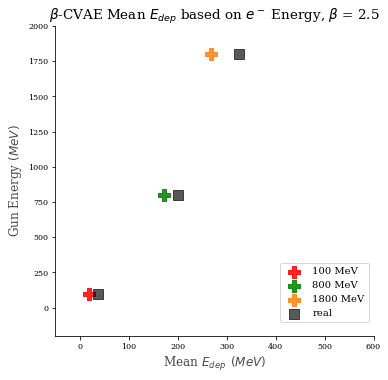

Train Epoch: 150 [0/50000 (0%)]	Loss: 188.189551
Train Epoch: 150 [5000/50000 (10%)]	Loss: 143.290283
Train Epoch: 150 [10000/50000 (20%)]	Loss: 178.447070
Train Epoch: 150 [15000/50000 (30%)]	Loss: 148.093579
Train Epoch: 150 [20000/50000 (40%)]	Loss: 177.234766
Train Epoch: 150 [25000/50000 (50%)]	Loss: 217.585425
Train Epoch: 150 [30000/50000 (60%)]	Loss: 168.425830
Train Epoch: 150 [35000/50000 (70%)]	Loss: 167.823035
Train Epoch: 150 [40000/50000 (80%)]	Loss: 190.090637
Train Epoch: 150 [45000/50000 (90%)]	Loss: 189.279785
====> Epoch: 150 Average loss: 175.8038
====> Test set loss: 190.6755
(325.5882891382654, 275.34882)


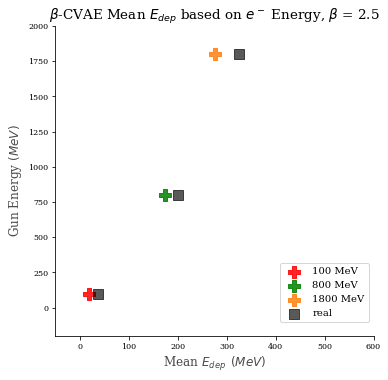

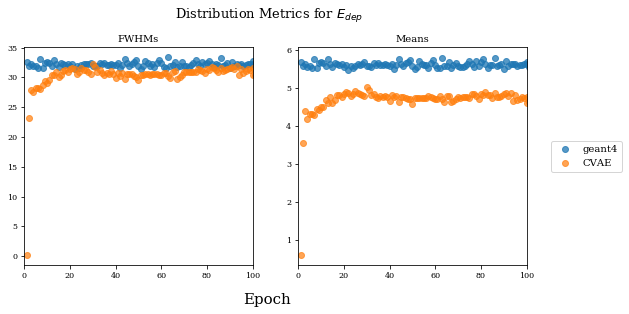

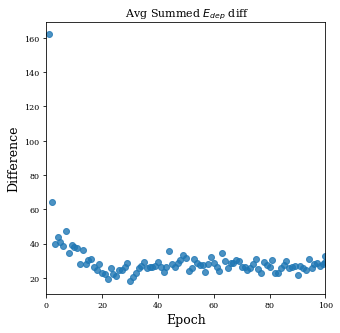

Train Epoch: 151 [0/50000 (0%)]	Loss: 184.432104
Train Epoch: 151 [5000/50000 (10%)]	Loss: 146.588940
Train Epoch: 151 [10000/50000 (20%)]	Loss: 179.018774
Train Epoch: 151 [15000/50000 (30%)]	Loss: 148.211523
Train Epoch: 151 [20000/50000 (40%)]	Loss: 175.992114
Train Epoch: 151 [25000/50000 (50%)]	Loss: 219.135156
Train Epoch: 151 [30000/50000 (60%)]	Loss: 170.099548
Train Epoch: 151 [35000/50000 (70%)]	Loss: 162.969568
Train Epoch: 151 [40000/50000 (80%)]	Loss: 189.235376
Train Epoch: 151 [45000/50000 (90%)]	Loss: 189.942822
====> Epoch: 151 Average loss: 175.6047
====> Test set loss: 190.7858


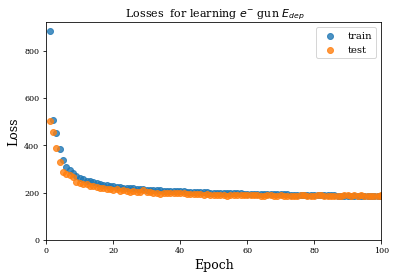

(325.5882891382654, 269.2443)


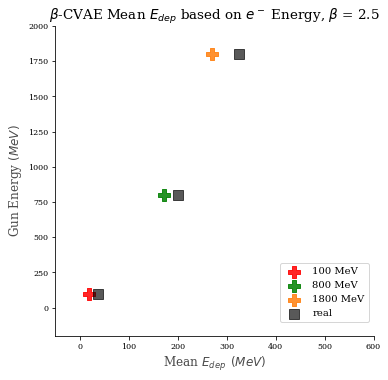

(325.5882891382654, 272.86597)


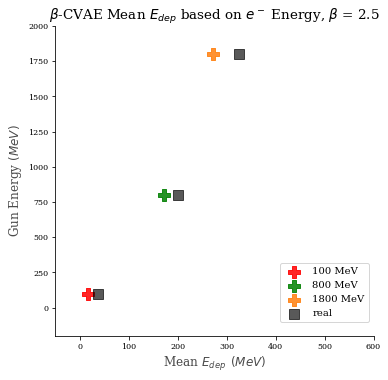

Train Epoch: 152 [0/50000 (0%)]	Loss: 189.754834
Train Epoch: 152 [5000/50000 (10%)]	Loss: 146.751733
Train Epoch: 152 [10000/50000 (20%)]	Loss: 182.238940
Train Epoch: 152 [15000/50000 (30%)]	Loss: 148.632202
Train Epoch: 152 [20000/50000 (40%)]	Loss: 170.438452
Train Epoch: 152 [25000/50000 (50%)]	Loss: 217.058203
Train Epoch: 152 [30000/50000 (60%)]	Loss: 170.626270
Train Epoch: 152 [35000/50000 (70%)]	Loss: 164.719507
Train Epoch: 152 [40000/50000 (80%)]	Loss: 192.418481
Train Epoch: 152 [45000/50000 (90%)]	Loss: 185.028076
====> Epoch: 152 Average loss: 175.4841
====> Test set loss: 190.7820
(325.5882891382654, 269.75146)


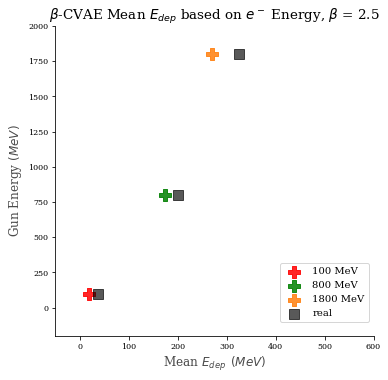

torch.Size([20, 1, 32, 32]) torch.Size([20, 1])
(-0.10143679, 15.013709)
(-0.17221229, 47.35042)
(-0.15498108, 27.562117)
(-0.035566512, 15.250294)
(-0.055805326, 46.196194)


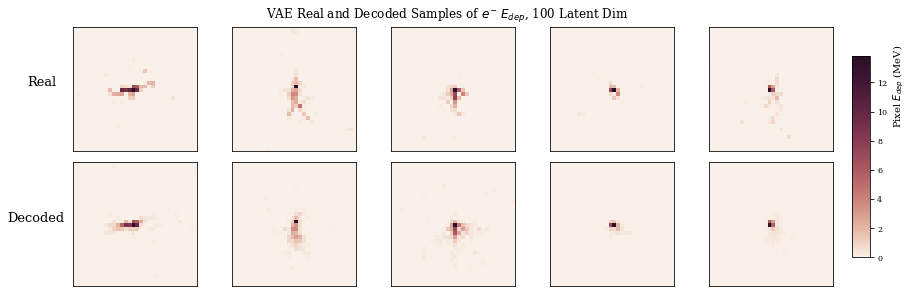

21.926012


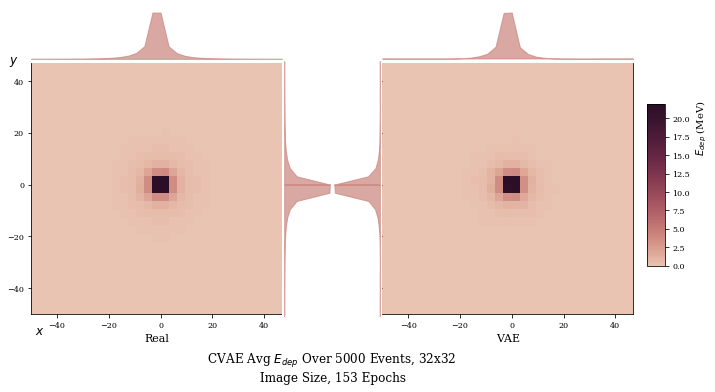

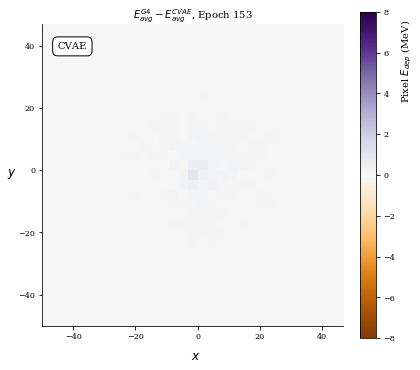

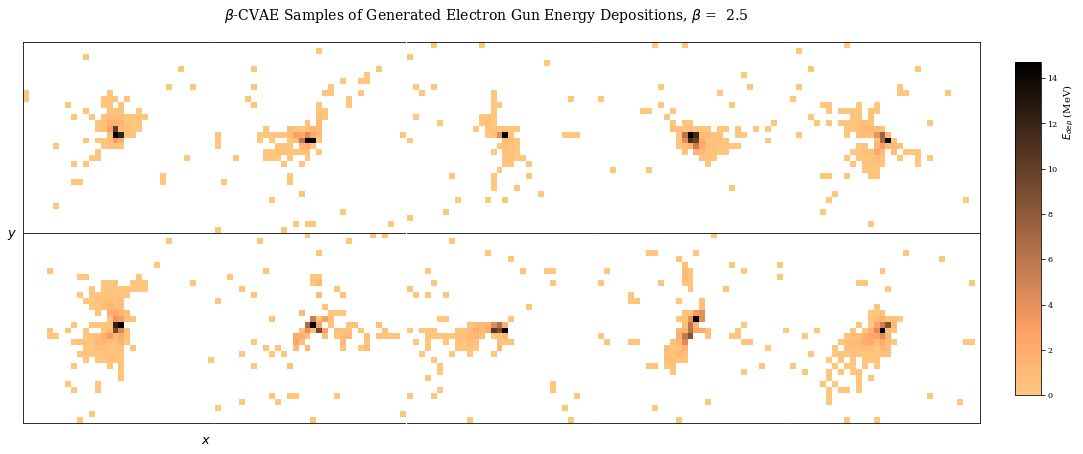

Train Epoch: 153 [0/50000 (0%)]	Loss: 188.850977
Train Epoch: 153 [5000/50000 (10%)]	Loss: 142.733521
Train Epoch: 153 [10000/50000 (20%)]	Loss: 183.354163
Train Epoch: 153 [15000/50000 (30%)]	Loss: 149.163208
Train Epoch: 153 [20000/50000 (40%)]	Loss: 165.515430
Train Epoch: 153 [25000/50000 (50%)]	Loss: 216.416650
Train Epoch: 153 [30000/50000 (60%)]	Loss: 173.323022
Train Epoch: 153 [35000/50000 (70%)]	Loss: 165.905566
Train Epoch: 153 [40000/50000 (80%)]	Loss: 192.302380
Train Epoch: 153 [45000/50000 (90%)]	Loss: 189.795483
====> Epoch: 153 Average loss: 175.3620
====> Test set loss: 191.7452
(325.5882891382654, 271.7917)


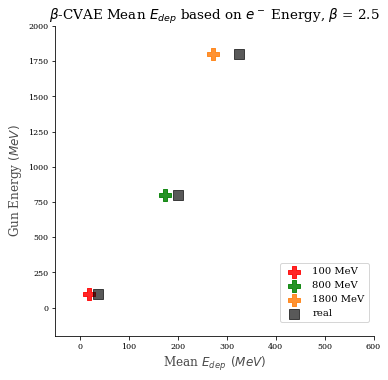

Train Epoch: 154 [0/50000 (0%)]	Loss: 190.934277
Train Epoch: 154 [5000/50000 (10%)]	Loss: 147.016382
Train Epoch: 154 [10000/50000 (20%)]	Loss: 175.977832
Train Epoch: 154 [15000/50000 (30%)]	Loss: 149.189966
Train Epoch: 154 [20000/50000 (40%)]	Loss: 173.823645
Train Epoch: 154 [25000/50000 (50%)]	Loss: 215.831812
Train Epoch: 154 [30000/50000 (60%)]	Loss: 176.112939
Train Epoch: 154 [35000/50000 (70%)]	Loss: 164.980176
Train Epoch: 154 [40000/50000 (80%)]	Loss: 189.813330
Train Epoch: 154 [45000/50000 (90%)]	Loss: 188.920874
====> Epoch: 154 Average loss: 175.1858
====> Test set loss: 191.6928
(325.5882891382654, 272.1285)


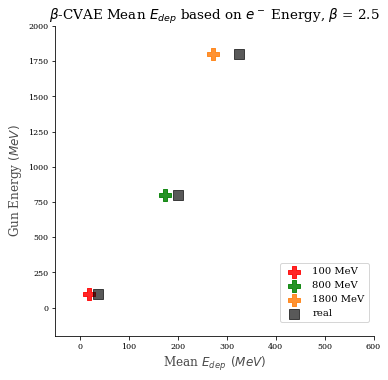

Train Epoch: 155 [0/50000 (0%)]	Loss: 186.836609
Train Epoch: 155 [5000/50000 (10%)]	Loss: 145.000708
Train Epoch: 155 [10000/50000 (20%)]	Loss: 183.876184
Train Epoch: 155 [15000/50000 (30%)]	Loss: 147.770093
Train Epoch: 155 [20000/50000 (40%)]	Loss: 168.695032
Train Epoch: 155 [25000/50000 (50%)]	Loss: 215.966406
Train Epoch: 155 [30000/50000 (60%)]	Loss: 170.326758
Train Epoch: 155 [35000/50000 (70%)]	Loss: 169.952258
Train Epoch: 155 [40000/50000 (80%)]	Loss: 186.271204
Train Epoch: 155 [45000/50000 (90%)]	Loss: 189.505908
====> Epoch: 155 Average loss: 174.9961
====> Test set loss: 191.1499
(325.5882891382654, 271.93967)


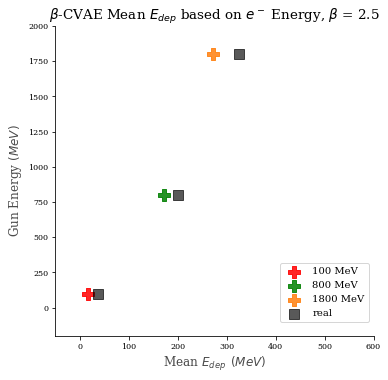

Train Epoch: 156 [0/50000 (0%)]	Loss: 188.236548
Train Epoch: 156 [5000/50000 (10%)]	Loss: 146.876953
Train Epoch: 156 [10000/50000 (20%)]	Loss: 176.236304
Train Epoch: 156 [15000/50000 (30%)]	Loss: 149.967407
Train Epoch: 156 [20000/50000 (40%)]	Loss: 171.611462
Train Epoch: 156 [25000/50000 (50%)]	Loss: 221.367407
Train Epoch: 156 [30000/50000 (60%)]	Loss: 169.408276
Train Epoch: 156 [35000/50000 (70%)]	Loss: 170.596753
Train Epoch: 156 [40000/50000 (80%)]	Loss: 183.196533
Train Epoch: 156 [45000/50000 (90%)]	Loss: 181.725891
====> Epoch: 156 Average loss: 174.9262


Process Process-9013:
Process Process-9015:
Process Process-9016:
Process Process-9010:
Process Process-9014:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-9012:
Process Process-9011:
Process Process-9009:
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
    self.run()
    self.run()
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/py

KeyboardInterrupt: 

  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    return recv()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/multiprocessing/queue.py", l

In [115]:
# mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/CVAE/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
# #mydir = None
# if mydir != None:
#     try:
#         os.makedirs(mydir)
#     except OSError as e:
#         if e.errno != errno.EEXIST:
#             raise

#     with open(mydir + 'NetworkInfo.txt', 'w') as f:
#         print >> f, 'model:', model
#         print >> f, 'normalization scale:', norm_scale
#         print >> f, 'latent dimensionality:', zdim
#         print >> f, 'image height/width:', imageSize
#         print >> f, 'loss function: MSE + KL div'
#         print >> f, 'batch size:', batchSize
#         print >> f, 'epochs:', num_epochs
#         print >> f, 'beta:', beta
#         print >> f, 'gun Energy:', energy
#         print >> f, 'last activation layer:', last_decode_act
#         print >> f, 'leakiness', leakiness
#         print >> f, 'batch size:', batchSize
#         print >> f, 'unnormalize loss:', unnormalize_loss


#num_epochs = 250
for epoch in range(100, num_epochs + 101):
    data_avg, n_events = make_samples(model, avg = True, conditions= MeVs, scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data, n_events = make_samples(model, avg = False, conditions= MeVs, scale= scale, norm_scale = norm_scale, 
                                  zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 5000)
    genx_FWHM = hist_width(np.sum(data_avg[1],1))
    realx_FWHM = hist_width(np.sum(data_avg[0],1))
    genx_mean = np.sum(data_avg[1],1).mean()
    #print genx_mean
    realx_mean = np.sum(data_avg[0],1).mean()
    sum_difference = calc_sum_difference(data_avg)
    sum_differences.append(sum_difference)
    genx_FWHMs.append(genx_FWHM)
    realx_FWHMs.append(realx_FWHM)
    genx_means.append(genx_mean)
    realx_means.append(realx_mean)
    epochs.append(epoch)
    #plot_means_stds(stats_r, stats_f, trim = 11, save_dir = mydir)
    #stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 6)
    plot_conditional_means(model, conditions_lists, save_dir=mydir)
    if epoch % 4 == 1:
        plot_reconstructions(model, save_dir=mydir, conv=False, simple=False, n=5, epoch = epoch)
        plot_avg_both(data_avg[0],data_avg[1], n_events, epoch = epoch, imageSize=imageSize, save_dir = mydir)
        plot_difference(data_avg, epoch = epoch, save_dir=mydir, imageSize=imageSize, n_events = n_events)
        samples(source=model, epoch = epoch, conds = MeVs, zdim = zdim, beta=beta, norm_scale = norm_scale, scale = scale, imageSize=imageSize, last_decode_act = last_decode_act, device=device, save_dir = mydir)
    if epoch % 10 == 1:
        plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, n_epochs=num_epochs, save_dir = mydir)
        plot_sum_difference(sum_differences, epochs=epochs, n_epochs=num_epochs, save_dir = mydir)
    train(epoch, train_losses)
    test(epoch, test_losses)
    if epoch % 10 == 1:
        plot_losses(train_losses, test_losses, epochs = epochs, n_epochs=num_epochs, save_dir = mydir)

        plot_conditional_means(model, conditions_lists, save_dir=mydir)
    if epoch == num_epochs:
        samples(source=model,  epoch = epoch, conds = MeVs, zdim=zdim, beta = beta, norm_scale=norm_scale, scale = scale, imageSize = imageSize, device=device, last_decode_act= last_decode_act, rows=1,columns=1, save_dir=mydir)
        
    

(325.5882891382654, 268.87653)


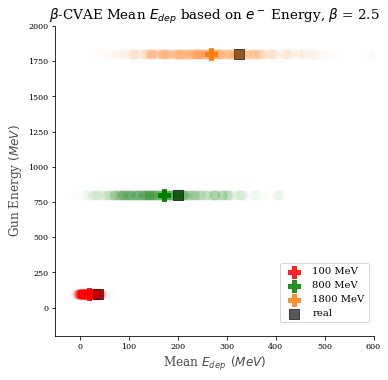

In [116]:


#del epochs[270], train_losses[270], test_losses[270], genx_FWHMs[270], realx_FWHMs[270], genx_means[270], realx_means[270]
#plot_losses(train_losses, test_losses, epochs = epochs, n_epochs=num_epochs, save_dir = mydir)
plot_conditional_means(model, conditions_lists, save_dir=mydir, w_EventMeans=True)

In [49]:
MakeGif = True
gif_filename =  mydir + 'VAE_EGun_Erecon_GIF_'  + str(batchSize) + "BatchSize_" + str(num_epochs) + "Epochs_" + str(zdim) +"LatentDim.gif"
        
import imageio
if MakeGif == True:
    png_dir = mydir
    images = []
    file_paths = []
    for subdir, dirs, files in os.walk(png_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            #if file_path.endswith(".pdf"):
            if "EdepFor5Events" in file_path:
                file_paths.append(file_path)
    #print file_paths
    #file_paths.sort(key=float) 
    file_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for i in range(len(file_paths)):      
        images.append(imageio.imread(file_paths[i]))

    imageio.mimsave(gif_filename, images)


ValueError: Could not find a format to read the specified file in mode 'i'

In [ ]:
plot_reconstructions(model, save_dir=None, conv=False, simple=False, n=7, epoch = epoch)

In [ ]:
mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/VAE/2018-06-06_20-02-59/"
from matplotlib import gridspec
data_avg, n_events = make_samples(model, avg = True, n_events = 5000)
data, n_events = make_samples(model, avg = False, n_events = 5000)

plot_avg_both(data_avg[0],data_avg[1], n_events, save_dir = mydir,  epoch = epoch)
plot_difference(data_avg, epoch = epoch, save_dir=mydir, norm_scale = norm_scale, n_events = n_events)
samples(model, epoch = epoch, save_dir = mydir)
print mydir

In [15]:
#THIS IS JUST A DIFFERENT WAY OF PLOTTING WHAT IS BELOW, BELOW IS MORE TIGHT LAYOUT

def new_samples1(model, epoch=epoch, imageSize=imageSize, norm_scale = norm_scale, scale = scale):
    sample = torch.randn(64, zdim).to(device)
    sample = model.decode(sample).cpu()
    sample_new = sample.view(64, 1, imageSize, imageSize).detach().numpy().squeeze()
    data = unnormalize(sample_new, scale = scale, norm_scale = norm_scale)


    columns = 3
    rows = 3
    etaran = (-50,50)
    phiran = (-50,50)
    extent = phiran + etaran
    print data.shape
    fig, axes =plt.subplots(rows,columns, figsize=(6, 6), sharex=True,sharey=True)

    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            image_array = data[event_number ]

            image_array[image_array <= 0] = np.nan
            #cmap = sns.cubehelix_palette(dark = 0.4, light=0.95, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)

            plt.axis('on')
            im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
            axes[i,j].set_xticklabels([])
            axes[i,j].set_yticklabels([])
            axes[i,j].xaxis.set_ticks_position('none')
            axes[i,j].yaxis.set_ticks_position('none')
            event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.66])

    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=0.00, hspace=0)
    fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y=0.95)
    plt.show()
    
    return

new_samples1(model, epoch = epoch)

RuntimeError: size mismatch, m1: [64 x 100], m2: [101 x 650] at /home/chris/pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249

In [ ]:
first_dim = np.linspace(-3.,3.,10)
first_dim = first_dim[...,np.newaxis]
second_dim = np.linspace(-3.,3.,10)
second_dim = second_dim[...,np.newaxis]
first_two = np.concatenate((first_dim,second_dim),1)
rest_noise = np.ones((10,zdim - 2))
latent2d_exploration = torch.FloatTensor(np.concatenate((first_two,rest_noise),1)).to(device)
sample = model.decode(latent2d_exploration).cpu()
data = sample.view(10, 1, imageSize, imageSize).detach().numpy().squeeze()
data.shape

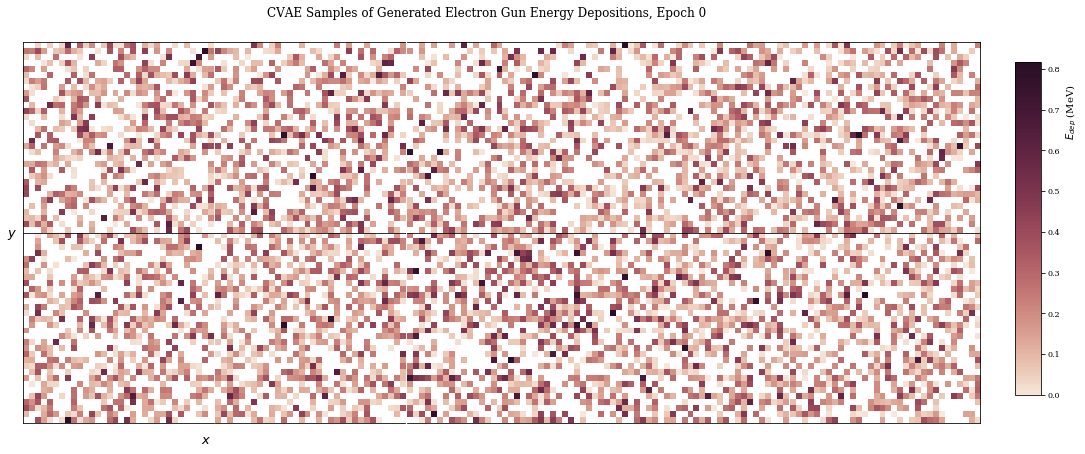

In [55]:
energies_list, _ = normalize(np.array([800,100,1800]),norm_scale='-1to1')
MeV800_test = np.full(5000, energies_list[0])
MeV100_test = np.full(5000, energies_list[1])
MeV1800_test = np.full(5000, energies_list[2])
#data_100 = make_samples(model, avg=True, n_events = 500, conditions=MeV100_test)
#data_100 = make_samplesmake_samples(model, avg=False, conditions, scale, norm_scale, zdim, device, imageSize, normed_array, n_events=500, real=True, fake = True)
#samples(model, epoch = epoch, conds = MeV2000_test, save_dir = mydir)
samples(model, epoch = epoch, conds = MeV1800_test, zdim=zdim,  beta=beta, norm_scale =norm_scale, 
        scale=scale, imageSize=imageSize, last_decode_act=last_decode_act, device=device, save_dir=None, rows=2, columns=5)

In [56]:
data_avg, n_events = make_samples(model, avg = False, conditions= MeV1800_test, scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)

In [284]:
print data_avg[1].mean()
print image_array_1800MeV.mean()

0.18005897
0.3179573136115865


In [ ]:
def plot_conditional_means(model, conditions_lists, scale = scale, norm_scale = norm_scale, 
                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000):

    data_avg_100, n_events = make_samples(model, avg = True, conditions= conditions_lists[0], scale = scale, norm_scale = norm_scale, 
                                          zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_800, n_events = make_samples(model, avg = True, conditions= conditions_lists[1], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
    data_avg_1800, n_events = make_samples(model, avg = True, conditions= conditions_lists[2], scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)

    MeV100_mean = data_avg_100[1].sum()
    MeV800_mean = data_avg_800[1].sum()
    MeV1800_mean = data_avg_1800[1].sum()

    MeV100_real = image_array_100MeV.sum()
    MeV800_real = image_array_800MeV.sum()
    MeV1800_real = image_array_1800MeV.sum()

    fig = plt.figure(figsize=(5.7,5.7))
    plt.scatter(MeV100_mean, 100, marker='P', s=85, alpha = 0.75, color = 'red', label = '100 MeV')
    plt.scatter(MeV100_real, 100, marker = 's', s = 100, alpha = 0.5, color = 'black')

    plt.scatter(MeV800_mean, 800, marker='P', s=85, alpha = 0.75, color = 'green', label = '800 MeV')
    plt.scatter(MeV800_real, 800, marker = 's', s = 100, alpha = 0.5, color = 'black')

    plt.scatter(MeV1800_mean, 1800, marker='P', s=85, alpha = 0.75, color= u'#ff7f0e', label = '1800 MeV')
    plt.scatter(MeV1800_real, 1800, marker = 's', s = 100, alpha = 0.5, color = 'black',  label = 'real')

    plt.ylim(-200,2000)
    plt.xlim(-.05, 0.40)
    plt.title(r"CVAE Mean $E_{dep}$ Conditioned on Gun Energy", fontsize = 13.5, alpha=0.92)
    plt.xlabel(r"Mean $\mathit{E_{dep}} \; \, (MeV) $", fontsize=12, fontweight='light', alpha = 0.7)
    plt.ylabel(r"Gun Energy $(MeV)$", fontsize=12, fontweight='light', alpha = 0.7)
    plt.xticks(np.arange(0, MeV1800_real + 0.1, step=0.1))
    plt.legend(loc='best', bbox_to_anchor=(1., 0.25), fontsize=10)
    sns.despine(left=False)
    
    plt.show()
    
    return
    
conditions_lists= [MeV100_test, MeV800_test, MeV1800_test]

plot_conditional_means(model, conditions_lists)


def calc_means_stds(imageSize=imageSize, n_times= 50):
    means_r_lists = []
    stds_r_lists = []
    means_f_lists = []
    stds_f_lists = []
    for i in range(n_times):
        data_avg, n_events = make_samples(model, avg = True, conditions= MeVs, scale = scale, norm_scale = norm_scale, 
                                      zdim = zdim, device = device, imageSize = imageSize, normed_array=normed_array, n_events = 5000)
        data_avg[1][data_avg[1] < 0] = 0.00000001
        if imageSize == 64:
            mini = -31.5
            maxi = 32.5
        elif imageSize == 32:
            mini = -15.5
            maxi = 16.5
        #bins = np.arange(-16,17,1)
        #bins = 0.5*(bins[1:] + bins[:-1])
        bins = np.tile(np.arange(mini,maxi,1),imageSize).reshape(imageSize,imageSize)
        #bins = np.tile(bins,imageSize).reshape(imageSize,imageSize)
        #mids = 0.5*(bins[:] + bins[:])
        #print(bins.shape)
        #print(data_set.shape, bins.shape, data_avg[0].shape)
        means_r = np.average(bins, weights=data_avg[0], axis = 1)
        stds_r = np.sqrt(np.average((bins - means_r)**2, weights=data_avg[0], axis=1))
        means_r_lists.append(means_r)
        stds_r_lists.append(stds_r)
        means_f = np.average(bins, weights=data_avg[1], axis = 1)
        stds_f = np.sqrt(np.average((bins - means_f)**2, weights=data_avg[1], axis=1))
        means_f_lists.append(means_f)
        stds_f_lists.append(stds_f)
    return [means_r_lists, stds_r_lists], [means_f_lists, stds_f_lists]

#stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 20)

def plot_means_stds(stats_r, stats_f, save_dir = mydir, imageSize=imageSize, trim = 12):
    slice_ixs = np.arange(0,imageSize,1)
    if len(stats_r[0]) < 2:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].scatter(slice_ixs, means_lists)
        axes[1].scatter(slice_ixs, stds_lists)
    else:
        
        #trim = 10
        means_r_lists = stats_r[0]
        stds_r_lists = stats_r[1]
        std_errs_r = np.array(stds_r_lists).std(0)
        mean_errs_r = np.array(means_r_lists).std(0)
        print(mean_errs_r.shape)
        means_r = np.array(means_r_lists).mean(0)
        stds_r = np.array(stds_r_lists).mean(0)
        means_f_lists = stats_f[0]
        stds_f_lists = stats_f[1]
        std_errs_f = np.array(stds_f_lists).std(0)
        mean_errs_f = np.array(means_f_lists).std(0)
        means_f = np.array(means_f_lists).mean(0)
        stds_f = np.array(stds_f_lists).mean(0)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4.5))
        axes[0].plot(slice_ixs[trim:-trim], means_r[trim:-trim], 'o', label = 'Geant4')
        axes[1].plot(slice_ixs[trim:-trim], stds_r[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, means_r, yerr=mean_errs_r)
        #axes[1].errorbar(slice_ixs, stds_r, yerr=std_errs_r)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_r[trim:-trim]-mean_errs_r[trim:-trim], means_r[trim:-trim]+mean_errs_r[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_r[trim:-trim]-std_errs_r[trim:-trim], stds_r[trim:-trim]+std_errs_r[trim:-trim], alpha = 0.2)
        
        axes[0].plot(slice_ixs[trim:-trim], means_f[trim:-trim], 'o', label ='VAE')
        axes[1].plot(slice_ixs[trim:-trim], stds_f[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, np.array(means_lists).mean(0), yerr=mean_errs)
        #axes[1].errorbar(slice_ixs, np.array(stds_lists).mean(0), yerr=std_errs)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_f[trim:-trim]-mean_errs_f[trim:-trim], means_f[trim:-trim]+mean_errs_f[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_f[trim:-trim]-std_errs_f[trim:-trim], stds_f[trim:-trim]+std_errs_f[trim:-trim], alpha = 0.2)
        axes[0].set_ylim(-5,5)
        if imageSize == 64:
            axes[1].set_ylim(-2,20.5)
        else:
            axes[1].set_ylim(-2,8.5)
        axes[0].legend(bbox_to_anchor=[2.6, 0.5], loc='center right', fontsize=12.5)
        axes[0].set_ylabel("Mean", fontsize = 13)
        axes[1].set_ylabel("Std Dev", fontsize = 13)
        axes[0].set_xlabel("Cross-Section Number")
        axes[1].set_xlabel("Cross-Section Number")
        #plt.subplots_adjust(wspace=0, hspace=0)
        #fig.suptitle(r"VAE Means and Standard Deviations of Each Cross-Section of Average Image", fontsize=14)
        fig.suptitle(r"CVAE Means and Standard Deviations of Each Cross-Section of Average Image, " + str(imageSize) + "x" + str(imageSize), fontsize=14)
        if save_dir != None:
            plt.savefig(save_dir + "MetricsCross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
        plt.show()
    return

#plot_means_stds(stats_r, stats_f, trim = 11, save_dir = mydir)


KeyboardInterrupt: 

In [94]:
data_100, n_events = make_samples(model, avg = False, conditions= conditions_lists[0], scale= scale, norm_scale = norm_scale, 
                          zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 5000)
data_800, n_events = make_samples(model, avg = False, conditions= conditions_lists[1], scale= scale, norm_scale = norm_scale, 
                          zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 5000)
data_1800, n_events = make_samples(model, avg = False, conditions= conditions_lists[2], scale= scale, norm_scale = norm_scale, 
                          zdim = zdim, device = device, imageSize=imageSize, normed_array=normed_array, n_events = 5000)

MeV100_means = [x.sum() for x in data_100[1]]
MeV800_means = [x.sum() for x in data_800[1]]
MeV1800_means = [x.sum() for x in data_1800[1]]

In [96]:
np.array(MeV1800_means).mean()

272.5533

In [81]:
energy1800 = [1800 for i in data_1800[1]]

In [85]:
energy1800

[1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,
 1800,